c:\Users\adity\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\adity\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\adity\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


AttributeError: module 'tensorflow._api.v2.compat.v2.__internal__' has no attribute 'register_load_context_function'

In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf
from glob import glob

# Input/Output paths
input_root = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Dataset/"
output_root = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"

# Target duration (3 seconds)
TARGET_DURATION = 3.0

def process_audio(file_path, output_path):
    # Load audio
    try:
        y, sr = librosa.load(file_path, sr=None)  # Preserve native sample rate

        # Current duration
        current_duration = len(y) / sr

        # Case 1: Audio is longer than 3s → trim middle 3s
        if current_duration > TARGET_DURATION:
            start = int((len(y) - TARGET_DURATION * sr) // 2)
            y_processed = y[start : start + int(TARGET_DURATION * sr)]

        # Case 2: Audio is shorter than 3s → pad with silence
        else:
            silence_needed = int((TARGET_DURATION - current_duration) * sr)
            pad_left = silence_needed // 2
            pad_right = silence_needed - pad_left
            y_processed = np.concatenate([
                np.zeros(pad_left),
                y,
                np.zeros(pad_right)
            ])

        # Save processed file
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        sf.write(output_path, y_processed, sr)
        return True
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return False

# Initialize counters
real_count = 0
fake_count = 0

# Process all speaker directories
for speaker_dir in glob(os.path.join(input_root, "S*")):
    # Process Real files
    real_files = glob(os.path.join(speaker_dir, "Real", "*.wav"))
    for file in real_files:
        output_filename = f"real_{real_count + 1}.wav"
        output_path = os.path.join(output_root, "Real", output_filename)
        if process_audio(file, output_path):
            real_count += 1

    # Process Fake files
    fake_files = glob(os.path.join(speaker_dir, "Fake", "*.wav"))
    for file in fake_files:
        output_filename = f"fake_{fake_count + 1}.wav"
        output_path = os.path.join(output_root, "Fake", output_filename)
        if process_audio(file, output_path):
            fake_count += 1

print(f"Processing complete! Saved {real_count} real files and {fake_count} fake files to: {output_root}")

In [2]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from lime import lime_image
import tensorflow as tf

# 1. Feature Extraction (Mel-spectrogram)
def extract_mel_spectrogram(file_path, n_mels=128, target_length=128):
    """Extract normalized mel-spectrogram with fixed size"""
    y, sr = librosa.load(file_path, sr=22050)  # Resample to 22.05kHz
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Pad/Cut to fixed size
    if mel_spec_db.shape[1] < target_length:
        pad_width = target_length - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :target_length]

    # Normalize to [0,1]
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    return mel_spec_db

# 2. Load and preprocess data
def load_dataset(data_path):
    X = []
    y = []

    for label in ['Real', 'Fake']:
        class_path = os.path.join(data_path, label)
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                features = extract_mel_spectrogram(file_path)
                X.append(features)
                y.append(label)

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Add channel dimension for CNN
    X = X[..., np.newaxis]

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y)  # Real=1, Fake=0

    return X, y

# 3. CNN Model Architecture
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# 4. Training with Callbacks
def train_model(model, X_train, y_train, X_val, y_val, epochs=50):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
        ModelCheckpoint('best_model1.h5', monitor='val_accuracy', save_best_only=True)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    return history

# 5. LIME Explanation Wrapper
class AudioExplainer:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, images):
        # Convert LIME's RGB images back to grayscale
        if images.ndim == 4 and images.shape[3] == 3:
            images = images[..., 0]

        # Add channel dimension if needed
        if images.ndim == 3:
            images = images[..., np.newaxis]

        return self.model.predict(images)

# 6. Visualization Functions
def plot_spectrogram(spectrogram, title=""):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.squeeze(), aspect='auto', cmap='magma', origin='lower')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Bands')
    plt.tight_layout()
    plt.show()

def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Load and prepare data
    data_path = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
    X, y = load_dataset(data_path)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train model
    input_shape = X_train.shape[1:]
    model = create_model(input_shape)
    history = train_model(model, X_train, y_train, X_test, y_test, epochs=50)

    # Evaluate best model
    model = models.load_model('best_model1.h5')
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    # Plot training history
    plot_history(history)

    # LIME Explanations
    explainer = lime_image.LimeImageExplainer()
    model_wrapper = AudioExplainer(model)

    # Explain 3 random samples
    for i in np.random.choice(len(X_test), 3, replace=False):
        # Get sample and prediction
        sample = X_test[i]
        pred = model.predict(sample[np.newaxis, ...])[0][0]
        pred_class = 'Real' if pred > 0.5 else 'Fake'
        true_class = 'Real' if y_test[i] == 1 else 'Fake'

        print(f"\nSample {i}:")
        print(f"  True: {true_class}")
        print(f"  Predicted: {pred_class} ({pred:.4f})")

        # Show original spectrogram
        plot_spectrogram(sample, f"Original Spectrogram\nTrue: {true_class}, Predicted: {pred_class}")

        # Generate explanation
        explanation = explainer.explain_instance(
            sample.squeeze(),
            model_wrapper.predict_proba,
            top_labels=1,
            hide_color=0,
            num_samples=1000,
            batch_size=32
        )

        # Visualize explanation
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        plt.figure(figsize=(10, 4))
        plt.imshow(mask, cmap='coolwarm', origin='lower')
        plt.title('LIME Explanation\nRed: Supports prediction, Blue: Contradicts')
        plt.colorbar()
        plt.xlabel('Time Frames')
        plt.ylabel('Mel Bands')
        plt.tight_layout()
        plt.show()

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9030 - loss: 0.2555

113/113 ━━━━━━━━━━━━━━━━━━━━ 80s 621ms/step - accuracy: 0.9034 - loss: 0.2547 - val_accuracy: 0.4956 - val_loss: 2.8194 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 629ms/step - accuracy: 0.9877 - loss: 0.0481 - val_accuracy: 0.4956 - val_loss: 3.6016 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 79s 601ms/step - accuracy: 0.9925 - loss: 0.0257 - val_accuracy: 0.4956 - val_loss: 2.3731 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9930 - loss: 0.0206

113/113 ━━━━━━━━━━━━━━━━━━━━ 91s 678ms/step - accuracy: 0.9930 - loss: 0.0205 - val_accuracy: 0.7078 - val_loss: 0.7566 - learning_rate: 0.0010
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.9975 - loss: 0.0079

113/113 ━━━━━━━━━━━━━━━━━━━━ 106s 887ms/step - accuracy: 0.9975 - loss: 0.0079 - val_accuracy: 0.9878 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.9997 - loss: 0.0027

113/113 ━━━━━━━━━━━━━━━━━━━━ 144s 904ms/step - accuracy: 0.9997 - loss: 0.0027 - val_accuracy: 0.9900 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.9973 - loss: 0.0102

113/113 ━━━━━━━━━━━━━━━━━━━━ 95s 835ms/step - accuracy: 0.9973 - loss: 0.0101 - val_accuracy: 0.9933 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 1.0000 - loss: 0.0011

113/113 ━━━━━━━━━━━━━━━━━━━━ 101s 466ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 398ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9956 - val_loss: 0.0180 - learning_rate: 0.0010
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 50s 439ms/step - accuracy: 0.9990 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 6.0096e-04 - learning_rate: 0.0010
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 419ms/step - accuracy: 0.9996 - loss: 0.0022 - val_accuracy: 0.9989 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 473ms/step - accuracy: 0.9990 - loss: 0.0028 - val_accuracy: 0.9500 - val_loss: 0.1597 - learning_rate: 0.0010
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 459ms/step - accuracy: 1.0000 - loss: 9.3239e-04 - val_accuracy: 1.0000 - val_loss: 4.4664e-05 - learning_rate: 0.0010
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 520ms/step - accura

KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# ---------------------------
# Preprocessing
# ---------------------------
def preprocess_image(img_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.vgg16.preprocess_input(img_array)

# ---------------------------
# Grad-CAM
# ---------------------------
def compute_gradcam(model, image, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        class_idx = tf.argmax(predictions[0])
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(image, heatmap, alpha=0.4):
    img = image[0]
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img
    plt.imshow(np.uint8(superimposed_img))
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()

# ---------------------------
# Integrated Gradients
# ---------------------------
def interpolate_images(baseline, image, steps=50):
    alphas = tf.linspace(0.0, 1.0, steps+1)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = image - baseline
    return baseline + alphas_x * delta

def compute_integrated_gradients(model, image, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros_like(image)
    interpolated_images = interpolate_images(baseline, image, steps)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        preds = model(interpolated_images)
        pred_index = tf.argmax(preds[-1])
        target = preds[:, pred_index]

    grads = tape.gradient(target, interpolated_images)
    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grads = (image - baseline) * avg_grads
    return integrated_grads

def display_integrated_gradients(integrated_grads):
    attributions = tf.reduce_sum(tf.math.abs(integrated_grads), axis=-1)[0]
    attributions = attributions.numpy()
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())
    plt.imshow(attributions, cmap='hot')
    plt.axis('off')
    plt.title("Integrated Gradients")
    plt.colorbar()
    plt.show()

# ---------------------------
# Main Run
# ---------------------------
if __name__ == "__main__":
    # Load pre-trained model
    model = tf.keras.applications.VGG16(weights="imagenet")
    model.trainable = False

    # Load and preprocess image
    img_path = tf.keras.utils.get_file("elephant.jpg", "https://i.imgur.com/Bvro0YD.png")
    image = preprocess_image(img_path)
    
    # Grad-CAM
    heatmap = compute_gradcam(model, image, last_conv_layer_name="block5_conv3")
    display_gradcam(image, heatmap)

    # Integrated Gradients
    igrads = compute_integrated_gradients(model, tf.cast(image, tf.float32))
    display_integrated_gradients(igrads)


RecursionError: maximum recursion depth exceeded in comparison

In [12]:
from tensorflow.keras.models import load_model


AttributeError: module 'tensorflow._api.v2.compat.v2.__internal__' has no attribute 'register_load_context_function'

In [5]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import lime
from lime import lime_tabular
import shap

# ========================
# 1. FEATURE EXTRACTION
# ========================
def extract_features(file_path, n_mfcc=20, n_mels=128):
    y, sr = librosa.load(file_path, sr=22050)
    features = []

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    features.extend(np.mean(mfcc, axis=1))
    features.extend(np.std(mfcc, axis=1))

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel)
    features.extend(np.mean(mel_db, axis=1))
    features.extend(np.std(mel_db, axis=1))

    features.extend(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
    features.extend(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
    features.extend(np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1))
    features.extend(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend(np.mean(chroma, axis=1))
    features.extend(np.std(chroma, axis=1))

    features.extend(np.mean(librosa.feature.zero_crossing_rate(y)))
    features.extend(np.mean(librosa.feature.rms(y=y)))
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    features.extend(np.mean(y_harmonic))
    features.extend(np.mean(y_percussive))

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features.append(tempo)

    return np.array(features)


# ========================
# 2. LOAD DATA
# ========================
def load_dataset(data_path):
    X, y = [], []

    real_dir = os.path.join(data_path, 'Real')
    dummy_path = next((os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.wav')), None)

    if dummy_path is None:
        raise FileNotFoundError("No .wav file found in the 'Real' folder for feature dimension extraction.")

    feature_names = [f"feature_{i}" for i in range(len(extract_features(dummy_path)))]

    for label in ['Real', 'Fake']:
        class_path = os.path.join(data_path, label)
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                path = os.path.join(class_path, file)
                X.append(extract_features(path))
                y.append(label)

    X = np.array(X)
    y = LabelEncoder().fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, feature_names, scaler


# ========================
# 3. CREATE MODEL
# ========================
def create_tabular_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# ========================
# 4. EXPLANATIONS
# ========================
def explain_with_lime(model, X_train, X_sample, feature_names, class_names=['Fake', 'Real']):
    explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names,
                                                  class_names=class_names, mode='classification')
    return explainer.explain_instance(X_sample, predict_fn=model.predict, num_features=10)


def explain_with_shap(model, X_train, X_sample, feature_names):
    explainer = shap.DeepExplainer(model, X_train[:100])
    shap_values = explainer.shap_values(np.array([X_sample]))[0][0]

    plt.figure(figsize=(12, 5))
    shap.bar_plot(shap_values, feature_names=feature_names)
    plt.title("SHAP Feature Contributions")
    plt.tight_layout()
    plt.show()


def grad_cam_like_explanation(model, sample, feature_names):
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        pred = model(sample_tensor)

    grads = tape.gradient(pred, sample_tensor).numpy()[0]

    plt.figure(figsize=(12, 5))
    plt.barh(feature_names, grads)
    plt.xlabel("Gradient")
    plt.title("Grad-CAM Style Input Gradient Importance")
    plt.tight_layout()
    plt.show()


# ========================
# 5. MAIN EXECUTION
# ========================
if __name__ == "__main__":
    data_path = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
    X, y, feature_names, scaler = load_dataset(data_path)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = create_tabular_model(X_train.shape[1])
    callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint('best_tabular_model.h5', save_best_only=True)]

    model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=callbacks, verbose=1)
    model = models.load_model('best_tabular_model.h5')

    loss, acc = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {acc:.4f}")

    for i in np.random.choice(len(X_test), 3, replace=False):
        sample = X_test[i]
        pred = model.predict(sample[np.newaxis])[0][0]
        pred_class = 'Real' if pred > 0.5 else 'Fake'
        true_class = 'Real' if y_test[i] == 1 else 'Fake'

        print(f"\nSample {i}: True: {true_class}, Predicted: {pred_class} ({pred:.4f})")

        lime_exp = explain_with_lime(model, X_train, sample, feature_names)
        lime_exp.show_in_notebook()
        explain_with_shap(model, X_train, sample, feature_names)
        grad_cam_like_explanation(model, sample, feature_names)

        print("\nTop contributing LIME features:")
        for feature, weight in lime_exp.as_list()[:5]:
            print(f"{feature}: {weight:.4f}")


TypeError: 'numpy.float64' object is not iterable

In [7]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import lime
from lime import lime_tabular
import shap
import pandas as pd

# 1. Extended Feature Extraction
def extract_features(file_path, n_mfcc=20, n_mels=128):
    """Extract multiple audio features and combine them into a single feature vector"""
    y, sr = librosa.load(file_path, sr=22050)

    features = []

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    features.extend(mfcc_mean)
    features.extend(mfcc_std)

    # Mel Spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel)
    mel_mean = np.mean(mel_db, axis=1)
    mel_std = np.std(mel_db, axis=1)
    features.extend(mel_mean)
    features.extend(mel_std)

    # Spectral Features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

    features.append(np.mean(spectral_centroid))
    features.append(np.mean(spectral_bandwidth))
    features.append(np.mean(spectral_contrast, axis=1))
    features.append(np.mean(spectral_rolloff))

    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend(np.mean(chroma, axis=1))
    features.extend(np.std(chroma, axis=1))

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))

    # RMS Energy
    rms = librosa.feature.rms(y=y)
    features.append(np.mean(rms))

    # Harmonic and Percussive
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    features.append(np.mean(y_harmonic))
    features.append(np.mean(y_percussive))

    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features.append(tempo)

    return np.array(features)

# 2. Load and preprocess data
def load_dataset(data_path):
    X = []
    y = []

    real_dir = os.path.join(data_path, 'Real')
    dummy_path = next((os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.wav')), None)

    if dummy_path is None:
        raise FileNotFoundError("No .wav file found in the 'Real' folder for feature dimension extraction.")

    feature_names = [f"feature_{i}" for i in range(len(extract_features(dummy_path)))]

    for label in ['Real', 'Fake']:
        class_path = os.path.join(data_path, label)
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                features = extract_features(file_path)
                X.append(features)
                y.append(label)

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y)  # Real=1, Fake=0

    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y, feature_names, scaler

# 3. Neural Network Model for Tabular Data
def create_tabular_model(input_shape):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# 4. LIME Explanation for Tabular Data
def explain_with_lime(model, X_train, X_sample, feature_names, class_names=['Fake', 'Real']):
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )

    exp = explainer.explain_instance(
        data_row=X_sample,
        predict_fn=model.predict,
        num_features=10
    )

    return exp

# 5. SHAP Explanation for Tabular Data
def explain_with_shap(model, X_train, X_sample):
    explainer = shap.KernelExplainer(model.predict, X_train)
    shap_values = explainer.shap_values(X_sample)
    return shap_values

# 6. Visualization Functions
def plot_lime_explanation(exp):
    fig = exp.as_pyplot_figure()
    plt.tight_layout()
    plt.show()

def plot_shap_explanation(shap_values, X_sample):
    shap.initjs()
    shap.force_plot(shap_values[0], X_sample, matplotlib=True)
    plt.show()

def plot_feature_importance(exp, feature_names):
    lime_list = exp.as_list()
    features = [x[0] for x in lime_list]
    scores = [x[1] for x in lime_list]

    plt.figure(figsize=(10, 6))
    plt.barh(features, scores)
    plt.xlabel('Importance Score')
    plt.title('LIME Feature Importance')
    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Load and prepare data
    data_path = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
    X, y, feature_names, scaler = load_dataset(data_path)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train model
    model = create_tabular_model(X_train.shape[1])

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint('best_tabular_model.h5', save_best_only=True)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate best model
    model = models.load_model('best_tabular_model.h5')
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    # LIME and SHAP Explanations
    for i in np.random.choice(len(X_test), 3, replace=False):
        sample = X_test[i]
        pred = model.predict(sample[np.newaxis, ...])[0][0]
        pred_class = 'Real' if pred > 0.5 else 'Fake'
        true_class = 'Real' if y_test[i] == 1 else 'Fake'

        print(f"\nSample {i}:")
        print(f"  True: {true_class}")
        print(f"  Predicted: {pred_class} ({pred:.4f})")

        # Generate LIME explanation
        exp = explain_with_lime(model, X_train, sample, feature_names)
        plot_lime_explanation(exp)
        plot_feature_importance(exp, feature_names)

        # Generate SHAP explanation
        shap_values = explain_with_shap(model, X_train, sample[np.newaxis, :])
        plot_shap_explanation(shap_values, sample)

        # Show raw feature values
        print("\nTop contributing features:")
        top_features = exp.as_list()[:5]  # Get top 5 features
        for feature, weight in top_features:
            feat_idx = int(feature.split('_')[-1]) if 'feature_' in feature else -1
            if feat_idx >= 0 and feat_idx < len(feature_names):
                print(f"{feature_names[feat_idx]}: {weight:.4f} (value: {sample[feat_idx]:.4f})")
            else:
                print(f"{feature}: {weight:.4f}")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (329,) + inhomogeneous part.

In [11]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import lime
from lime import lime_tabular
import shap

# ========================
# 1. FEATURE EXTRACTION
# ========================
def extract_features(file_path, n_mfcc=20, n_mels=128):
    y, sr = librosa.load(file_path, sr=22050)
    features = []

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    features.append(np.mean(mfcc, axis=1))  # Mean MFCC values
    features.append(np.std(mfcc, axis=1))   # Std of MFCC values

    # Mel Spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel)
    features.append(np.mean(mel_db, axis=1))  # Mean Mel spectrogram
    features.append(np.std(mel_db, axis=1))   # Std Mel spectrogram

    # Spectral features
    features.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))  # Scalar mean spectral centroid
    features.append(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))  # Scalar mean spectral bandwidth
    features.append(np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1))  # Mean spectral contrast
    features.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))  # Scalar mean spectral rolloff

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.append(np.mean(chroma, axis=1))  # Mean chroma
    features.append(np.std(chroma, axis=1))   # Std chroma

    # Other features
    features.append(np.mean(librosa.feature.zero_crossing_rate(y)))  # Scalar mean ZCR
    features.append(np.mean(librosa.feature.rms(y=y)))  # Scalar mean RMS
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    features.append(np.mean(y_harmonic))  # Scalar mean harmonic
    features.append(np.mean(y_percussive))  # Scalar mean percussive

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features.append(tempo)  # Scalar tempo

    # Flatten the list of features into a single array
    return np.hstack(features)  # Concatenate into a single vector


# ========================
# 2. LOAD DATA
# ========================
def load_dataset(data_path):
    X, y = [], []
    dummy_path = os.path.join(data_path, 'Real', 'real_1.wav')
    feature_names = [f"feature_{i}" for i in range(len(extract_features(dummy_path)))]

    for label in ['Real', 'Fake']:
        class_path = os.path.join(data_path, label)
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                path = os.path.join(class_path, file)
                X.append(extract_features(path))
                y.append(label)

    X = np.array(X)
    y = LabelEncoder().fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, feature_names, scaler


# ========================
# 3. CREATE MODEL
# ========================
def create_tabular_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# ========================
# 4. EXPLANATIONS
# ========================
def explain_with_lime(model, X_train, X_sample, feature_names, class_names=['Fake', 'Real']):
    explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names,
                                                  class_names=class_names, mode='classification')
    return explainer.explain_instance(X_sample, predict_fn=model.predict, num_features=10)


def explain_with_shap(model, X_train, X_sample, feature_names):
    explainer = shap.DeepExplainer(model, X_train[:100])  # Use a subset for speed
    shap_values = explainer.shap_values(np.array([X_sample]))[0][0]

    plt.figure(figsize=(12, 5))
    shap.bar_plot(shap_values, feature_names=feature_names)
    plt.title("SHAP Feature Contributions")
    plt.tight_layout()
    plt.show()


def grad_cam_like_explanation(model, sample, feature_names):
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        pred = model(sample_tensor)

    grads = tape.gradient(pred, sample_tensor).numpy()[0]

    plt.figure(figsize=(12, 5))
    plt.barh(feature_names, grads)
    plt.xlabel("Gradient")
    plt.title("Grad-CAM Style Input Gradient Importance")
    plt.tight_layout()
    plt.show()


# ========================
# 5. MAIN EXECUTION
# ========================
if __name__ == "__main__":
    data_path = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
    X, y, feature_names, scaler = load_dataset(data_path)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = create_tabular_model(X_train.shape[1])
    callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint('best_tabular_model.h5', save_best_only=True)]

    model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=callbacks, verbose=1)
    model = models.load_model('best_tabular_model.h5')

    loss, acc = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {acc:.4f}")

    # Explain 3 random test samples
    for i in np.random.choice(len(X_test), 3, replace=False):
        sample = X_test[i]
        pred = model.predict(sample[np.newaxis])[0][0]
        pred_class = 'Real' if pred > 0.5 else 'Fake'
        true_class = 'Real' if y_test[i] == 1 else 'Fake'

        print(f"\nSample {i}: True: {true_class}, Predicted: {pred_class} ({pred:.4f})")

        lime_exp = explain_with_lime(model, X_train, sample, feature_names)
        lime_exp.show_in_notebook()
        explain_with_shap(model, X_train, sample, feature_names)
        grad_cam_like_explanation(model, sample, feature_names)

        print("\nTop contributing LIME features:")
        for feature, weight in lime_exp.as_list()[:5]:
            print(f"{feature}: {weight:.4f}")


Epoch 1/50
82/90 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9067 - loss: 0.2412

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9133 - loss: 0.2267 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 2/50
68/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0109

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9988 - loss: 0.0104 - val_accuracy: 1.0000 - val_loss: 7.4457e-04
Epoch 3/50
87/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0034

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 3.0038e-04
Epoch 4/50
79/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0016

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 1.4937e-04
Epoch 5/50
79/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0016

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 8.7875e-05
Epoch 6/50
80/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0035

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 5.3713e-05
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 9.3110e-05
Epoch 8/50
76/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0036

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9982 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 3.5426e-05
Epoch 9/50
86/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0056

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9982 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 2.5274e-05
Epoch 10/50
85/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.1785e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.2393e-04 - val_accuracy: 1.0000 - val_loss: 1.4505e-05
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.6935e-04 - val_accuracy: 1.0000 - val_loss: 1.8535e-05
Epoch 12/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 4.9889e-05
Epoch 13/50
84/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0025

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9983 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 9.3110e-06
Epoch 14/50
75/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.3335e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.3059e-04 - val_accuracy: 1.0000 - val_loss: 5.9166e-06
Epoch 15/50
76/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9430e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.8615e-04 - val_accuracy: 1.0000 - val_loss: 5.4139e-06
Epoch 16/50
80/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.8913e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.6909e-04 - val_accuracy: 1.0000 - val_loss: 5.0891e-06
Epoch 17/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.8243e-04 - val_accuracy: 1.0000 - val_loss: 6.1227e-04
Epoch 18/50
83/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4496e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.5274e-04 - val_accuracy: 1.0000 - val_loss: 2.9057e-06
Epoch 19/50
83/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.6781e-05

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.6173e-05 - val_accuracy: 1.0000 - val_loss: 2.2217e-06
Epoch 20/50
80/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8571e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.0844e-04 - val_accuracy: 1.0000 - val_loss: 1.9144e-06
Epoch 21/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1483e-04 - val_accuracy: 1.0000 - val_loss: 3.3927e-06
Epoch 22/50
77/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0030

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9991 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 1.6203e-06
Epoch 23/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9992 - loss: 9.4483e-04 - val_accuracy: 1.0000 - val_loss: 1.7321e-06
Epoch 24/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7591e-04 - val_accuracy: 1.0000 - val_loss: 1.8162e-06
Epoch 25/50
79/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.3229e-05

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.7678e-05 - val_accuracy: 1.0000 - val_loss: 1.2828e-06
Epoch 26/50
87/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.1412e-05

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.3155e-05 - val_accuracy: 1.0000 - val_loss: 1.1380e-06
Epoch 27/50
81/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4440e-05

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.4447e-05 - val_accuracy: 1.0000 - val_loss: 1.0600e-06
Epoch 28/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 8.7629e-04 - val_accuracy: 1.0000 - val_loss: 1.9799e-06
Epoch 29/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.9018e-04 - val_accuracy: 1.0000 - val_loss: 2.8988e-06
Epoch 30/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9987 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 3.8776e-06
Epoch 31/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.5821e-04 - val_accuracy: 1.0000 - val_loss: 1.4647e-06
Epoch 32/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0317e-04 - val_accuracy: 1.0000 - val_loss: 1.0733e-06


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.8925e-06

Test Accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

Sample 704: True: Fake, Predicted: Fake (0.0000)
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


IndexError: index 1 is out of bounds for axis 1 with size 1

In [9]:
from lime import lime_tabular
from IPython.display import display, HTML

def explain_with_lime(model, X_train, X_sample, feature_names, class_names=['Fake', 'Real']):
    def predict_proba_fn(x):
        preds = model.predict(x)
        return np.column_stack([1 - preds, preds])

    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )

    explanation = explainer.explain_instance(
        data_row=X_sample,
        predict_fn=predict_proba_fn,
        num_features=10
    )

    # Show in Jupyter cell
    display(HTML(explanation.as_html()))

    print("\n📌 Top LIME Feature Contributions:")
    for feature, weight in explanation.as_list():
        print(f"{feature:50s}: {weight:+.4f}")


In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt

def grad_cam_like_explanation(model, sample, feature_names):
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        prediction = model(sample_tensor)

    grads = tape.gradient(prediction, sample_tensor).numpy()[0]

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, grads, color='dodgerblue')
    plt.xlabel("Input Gradient")
    plt.title("Grad-CAM Style Feature Importance")
    plt.tight_layout()
    plt.show()


In [11]:
# Example loop for 3 random samples
for i in np.random.choice(len(X_test), 3, replace=False):
    sample = X_test[i]
    pred = model.predict(sample[np.newaxis])[0][0]
    pred_class = 'Real' if pred > 0.5 else 'Fake'
    true_class = 'Real' if y_test[i] == 1 else 'Fake'

    print(f"\n🎯 Sample Index: {i}")
    print(f"True Label   : {true_class}")
    print(f"Prediction   : {pred_class} ({pred:.4f})")

    # LIME
    explain_with_lime(model, X_train, sample, feature_names)

    # Grad-CAM-style
    grad_cam_like_explanation(model, sample, feature_names)


NameError: name 'X_test' is not defined

In [15]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import lime
from lime import lime_tabular
import shap


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
def load_dataset(data_path):
    X, y = [], []
    dummy_path = os.path.join(data_path, 'Real', 'real_1.wav')
    feature_names = [f"feature_{i}" for i in range(len(extract_features(dummy_path)))]

    for label in ['Real', 'Fake']:
        class_path = os.path.join(data_path, label)
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                path = os.path.join(class_path, file)
                X.append(extract_features(path))
                y.append(label)

    X = np.array(X)
    y = LabelEncoder().fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, feature_names, scaler


In [16]:
def extract_features(file_path, n_mfcc=20, n_mels=128):
    y, sr = librosa.load(file_path, sr=22050)
    features = []

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    features.append(np.mean(mfcc, axis=1))
    features.append(np.std(mfcc, axis=1))

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel)
    features.append(np.mean(mel_db, axis=1))
    features.append(np.std(mel_db, axis=1))

    features.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1))
    features.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.append(np.mean(chroma, axis=1))
    features.append(np.std(chroma, axis=1))

    features.append(np.mean(librosa.feature.zero_crossing_rate(y)))
    features.append(np.mean(librosa.feature.rms(y=y)))
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    features.append(np.mean(y_harmonic))
    features.append(np.mean(y_percussive))

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features.append(tempo)

    return np.hstack(features)


In [18]:
def create_tabular_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Load data
data_path = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
X, y, feature_names, scaler = load_dataset(data_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = create_tabular_model(X_train.shape[1])
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('audio_model.h5', save_best_only=True)
]
model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=callbacks, verbose=1)
model = models.load_model('model.h5')

loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")


Epoch 1/50
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8856 - loss: 0.2609

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8952 - loss: 0.2418 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 2/50
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0101

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 3/50
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0026

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 7.5114e-04
Epoch 4/50
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 3.3021e-04
Epoch 5/50
61/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0026

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 1.5262e-04
Epoch 6/50
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.6351e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6044e-04 - val_accuracy: 1.0000 - val_loss: 8.6536e-05
Epoch 7/50
65/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.2805e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3534e-04 - val_accuracy: 1.0000 - val_loss: 6.4390e-05
Epoch 8/50
63/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.3787e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4473e-04 - val_accuracy: 1.0000 - val_loss: 4.4552e-05
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 6.0195e-04
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9965 - loss: 0.0076 - val_accuracy: 1.0000 - val_loss: 5.3108e-05
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 8.7259e-05
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 7.5183e-04 - val_accuracy: 1.0000 - val_loss: 5.4965e-05
Epoch 13/50
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 7.3889e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 7.4551e-04 - val_accuracy: 1.0000 - val_loss: 3.4464e-05
Epoch 14/50
61/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.3151e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.4271e-04 - val_accuracy: 1.0000 - val_loss: 2.3745e-05
Epoch 15/50
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.0171e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.7986e-04 - val_accuracy: 1.0000 - val_loss: 1.7348e-05
Epoch 16/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9722e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9852e-04 - val_accuracy: 1.0000 - val_loss: 1.1189e-05
Epoch 17/50
61/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.8439e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7902e-04 - val_accuracy: 1.0000 - val_loss: 1.0341e-05
Epoch 18/50
63/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4527e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.4103e-04 - val_accuracy: 1.0000 - val_loss: 7.9871e-06
Epoch 19/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.1155e-04 - val_accuracy: 1.0000 - val_loss: 1.2979e-05
Epoch 20/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5816e-04 - val_accuracy: 1.0000 - val_loss: 1.7603e-05
Epoch 21/50
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.2137e-05

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.8094e-05 - val_accuracy: 1.0000 - val_loss: 7.4812e-06
Epoch 22/50
68/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.1593e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.0206e-04 - val_accuracy: 1.0000 - val_loss: 5.3802e-06
Epoch 23/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.7857e-04 - val_accuracy: 1.0000 - val_loss: 5.7474e-06
Epoch 24/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.9190e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.9189e-04 - val_accuracy: 1.0000 - val_loss: 3.3272e-06
Epoch 25/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 9.1067e-04 - val_accuracy: 1.0000 - val_loss: 4.8811e-05
Epoch 26/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 1.6663e-04
Epoch 27/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9594e-04 - val_accuracy: 1.0000 - val_loss: 4.1602e-06
Epoch 28/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.7954e-04 - val_accuracy: 1.0000 - val_loss: 6.1767e-05
Epoch 29/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3402e-05 - val_accuracy: 1.0000 - val_loss: 3.1210e-05


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.7097e-06

Test Accuracy: 1.0000


In [19]:
def explain_with_lime(model, X_train, X_sample, feature_names, class_names=['Fake', 'Real']):
    explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names,
                                                  class_names=class_names, mode='classification')
    return explainer.explain_instance(X_sample, predict_fn=model.predict, num_features=10)


def explain_with_shap(model, X_train, X_sample, feature_names):
    explainer = shap.DeepExplainer(model, X_train[:100])
    shap_values = explainer.shap_values(np.array([X_sample]))[0][0]

    shap.plots.bar(shap.Explanation(values=shap_values, feature_names=feature_names, data=X_sample))


def grad_cam_like_explanation(model, sample, feature_names):
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        pred = model(sample_tensor)

    grads = tape.gradient(pred, sample_tensor).numpy()[0]

    plt.figure(figsize=(12, 6))
    plt.barh(feature_names, grads)
    plt.xlabel("Gradient")
    plt.title("Grad-CAM Style Input Gradient Importance")
    plt.tight_layout()
    plt.show()


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import shap
import tensorflow as tf
from tqdm import tqdm

def explain_with_lime(model, X_train, X_sample, feature_names, class_names=['Fake', 'Real']):
    """Explain model prediction using LIME"""
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        verbose=False
    )

    # Wrapper function to format predictions correctly for LIME
    def predict_proba(x):
        preds = model.predict(x, verbose=0).flatten()
        return np.vstack([1-preds, preds]).T  # [prob_fake, prob_real]

    explanation = explainer.explain_instance(
        X_sample,
        predict_fn=predict_proba,
        num_features=min(10, len(feature_names))

    return explanation

def explain_with_shap(model, X_train, X_sample, feature_names):
    """Explain model prediction using SHAP"""
    # Wrapper function for SHAP
    def predict_fn(x):
        return model.predict(x, verbose=0)

    # Use KernelExplainer as more general purpose
    explainer = shap.KernelExplainer(
        predict_fn,
        shap.sample(X_train, 100)  # Use subset for background
    )

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_sample.reshape(1, -1))

    # Plot for binary classification
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Take values for positive class

    shap.force_plot(
        explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
        shap_values[0],
        feature_names=feature_names,
        matplotlib=True
    )

def grad_cam_like_explanation(model, sample, feature_names):
    """Gradient-based explanation similar to Grad-CAM"""
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        pred = model(sample_tensor)
        target = pred[:, 1] if pred.shape[1] == 2 else pred  # Handle binary vs multi-class

    grads = tape.gradient(target, sample_tensor).numpy()[0]

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(np.abs(grads))[::-1]
    plt.barh(np.array(feature_names)[sorted_idx], grads[sorted_idx])
    plt.xlabel("Gradient Magnitude")
    plt.title("Gradient-based Feature Importance")
    plt.tight_layout()
    plt.show()

# Example usage with random test samples
for i in np.random.choice(len(X_test), 3, replace=False):
    sample = X_test[i]
    pred = model.predict(sample[np.newaxis], verbose=0)[0]

    # Handle both binary (single output) and categorical (2 outputs) cases
    if len(pred) == 2:  # Categorical output
        pred_class = 'Real' if pred[1] > 0.5 else 'Fake'
        pred_prob = pred[1] if pred[1] > 0.5 else 1 - pred[1]
    else:  # Binary output
        pred_class = 'Real' if pred > 0.5 else 'Fake'
        pred_prob = pred if pred > 0.5 else 1 - pred

    true_class = 'Real' if y_test[i] == 1 else 'Fake'

    print(f"\nSample {i}: True: {true_class}, Predicted: {pred_class} ({pred_prob:.4f})")

    # LIME explanation
    lime_exp = explain_with_lime(model, X_train, sample, feature_names)
    lime_exp.show_in_notebook()

    # SHAP explanation
    explain_with_shap(model, X_train, sample, feature_names)

    # Gradient explanation
    grad_cam_like_explanation(model, sample, feature_names)

    # Print top LIME features
    print("\nTop contributing LIME features:")
    for feature, weight in lime_exp.as_list()[:5]:
        print(f"{feature}: {weight:.4f}")

SyntaxError: '(' was never closed (788784872.py, line 24)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import shap
import tensorflow as tf
from tqdm import tqdm

def explain_with_lime(model, X_train, X_sample, feature_names, class_names=['Fake', 'Real']):
    """Explain model prediction using LIME"""
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        verbose=False
    )

    # Wrapper function to format predictions correctly for LIME
    def predict_proba(x):
        preds = model.predict(x, verbose=0).flatten()
        return np.vstack([1-preds, preds]).T  # [prob_fake, prob_real]

    explanation = explainer.explain_instance(
        X_sample,
        predict_fn=predict_proba,
        num_features=min(10, len(feature_names))
    )

    return explanation

def explain_with_shap(model, X_train, X_sample, feature_names):
    """Explain model prediction using SHAP"""
    # Wrapper function for SHAP
    def predict_fn(x):
        return model.predict(x, verbose=0)

    # Use KernelExplainer as more general purpose
    explainer = shap.KernelExplainer(
        predict_fn,
        shap.sample(X_train, 100)  # Use subset for background
    )

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_sample.reshape(1, -1))

    # Plot for binary classification
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Take values for positive class

    shap.force_plot(
        explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
        shap_values[0],
        feature_names=feature_names,
        matplotlib=True
    )

def grad_cam_like_explanation(model, sample, feature_names):
    """Gradient-based explanation similar to Grad-CAM"""
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        pred = model(sample_tensor)
        target = pred[:, 1] if pred.shape[1] == 2 else pred  # Handle binary vs multi-class

    grads = tape.gradient(target, sample_tensor).numpy()[0]

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(np.abs(grads))[::-1]
    plt.barh(np.array(feature_names)[sorted_idx], grads[sorted_idx])
    plt.xlabel("Gradient Magnitude")
    plt.title("Gradient-based Feature Importance")
    plt.tight_layout()
    plt.show()

# Example usage with random test samples
for i in np.random.choice(len(X_test), 3, replace=False):
    sample = X_test[i]
    pred = model.predict(sample[np.newaxis], verbose=0)[0]

    # Handle both binary (single output) and categorical (2 outputs) cases
    if len(pred) == 2:  # Categorical output
        pred_class = 'Real' if pred[1] > 0.5 else 'Fake'
        pred_prob = pred[1] if pred[1] > 0.5 else 1 - pred[1]
    else:  # Binary output
        pred_class = 'Real' if pred > 0.5 else 'Fake'
        pred_prob = pred if pred > 0.5 else 1 - pred

    true_class = 'Real' if y_test[i] == 1 else 'Fake'

    print(f"\nSample {i}: True: {true_class}, Predicted: {pred_class} ({pred_prob:.4f})")

    # LIME explanation
    lime_exp = explain_with_lime(model, X_train, sample, feature_names)
    lime_exp.show_in_notebook()

    # SHAP explanation
    explain_with_shap(model, X_train, sample, feature_names)

    # Gradient explanation
    grad_cam_like_explanation(model, sample, feature_names)

    # Print top LIME features
    print("\nTop contributing LIME features:")
    for feature, weight in lime_exp.as_list()[:5]:
        print(f"{feature}: {weight:.4f}")

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import shap
import tensorflow as tf
from tqdm import tqdm

def explain_with_lime(model, X_train, X_sample, feature_names, class_names=['Fake', 'Real']):
    """Explain model prediction using LIME"""
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        verbose=False
    )

    # Wrapper function to format predictions correctly for LIME
    def predict_proba(x):
        preds = model.predict(x, verbose=0)
        if preds.ndim == 1:  # Binary classification case
            return np.vstack([1-preds, preds]).T
        return preds  # Multi-class case

    explanation = explainer.explain_instance(
        X_sample,
        predict_fn=predict_proba,
        num_features=min(10, len(feature_names))

    return explanation

def explain_with_shap(model, X_train, X_sample, feature_names):
    """Explain model prediction using SHAP"""
    # Wrapper function for SHAP
    def predict_fn(x):
        return model.predict(x, verbose=0)

    # Use KernelExplainer as more general purpose
    explainer = shap.KernelExplainer(
        predict_fn,
        shap.sample(X_train, 100)  # Use subset for background
    )

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_sample.reshape(1, -1))

    # Plot for binary classification
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Take values for positive class

    shap.plots.bar(shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
        feature_names=feature_names,
        data=X_sample
    ))

def grad_cam_like_explanation(model, sample, feature_names):
    """Gradient-based explanation similar to Grad-CAM"""
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        pred = model(sample_tensor)
        target = pred[:, 1] if pred.shape[1] == 2 else pred[0]  # Handle binary vs multi-class

    grads = tape.gradient(target, sample_tensor).numpy()[0]

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(np.abs(grads))[::-1]
    plt.barh(np.array(feature_names)[sorted_idx], grads[sorted_idx])
    plt.xlabel("Gradient Magnitude")
    plt.title("Gradient-based Feature Importance")
    plt.tight_layout()
    plt.show()

# Example usage with random test samples
for i in np.random.choice(len(X_test), 3, replace=False):
    sample = X_test[i]
    pred = model.predict(sample[np.newaxis], verbose=0)

    # Handle both binary (single output) and categorical (2 outputs) cases
    if pred.shape[1] == 2:  # Categorical output
        pred_class = 'Real' if pred[0,1] > 0.5 else 'Fake'
        pred_prob = float(pred[0,1] if pred[0,1] > 0.5 else 1 - pred[0,1])
    else:  # Binary output
        pred_class = 'Real' if pred[0,0] > 0.5 else 'Fake'
        pred_prob = float(pred[0,0] if pred[0,0] > 0.5 else 1 - pred[0,0])

    true_class = 'Real' if y_test[i] == 1 else 'Fake'

    print(f"\nSample {i}: True: {true_class}, Predicted: {pred_class} ({pred_prob:.4f})")

    # LIME explanation
    lime_exp = explain_with_lime(model, X_train, sample, feature_names)
    lime_exp.show_in_notebook()

    # SHAP explanation
    explain_with_shap(model, X_train, sample, feature_names)

    # Gradient explanation
    grad_cam_like_explanation(model, sample, feature_names)

    # Print top LIME features
    print("\nTop contributing LIME features:")
    for feature, weight in lime_exp.as_list()[:5]:
        print(f"{feature}: {weight:.4f}")

SyntaxError: '(' was never closed (3403632678.py, line 26)


Sample 2: True: Fake, Predicted: Fake (0.5568)


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


LIME explanation failed: index 1 is out of bounds for axis 1 with size 1


100%|██████████| 1/1 [00:15<00:00, 15.38s/it]


SHAP explanation failed: 'numpy.float64' object is not iterable


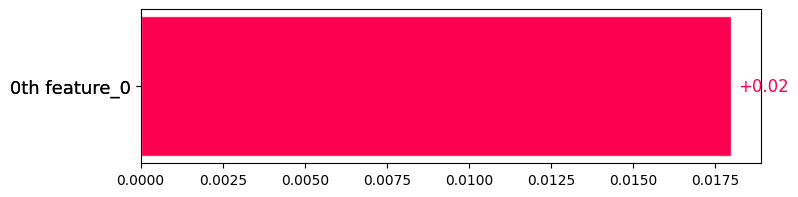

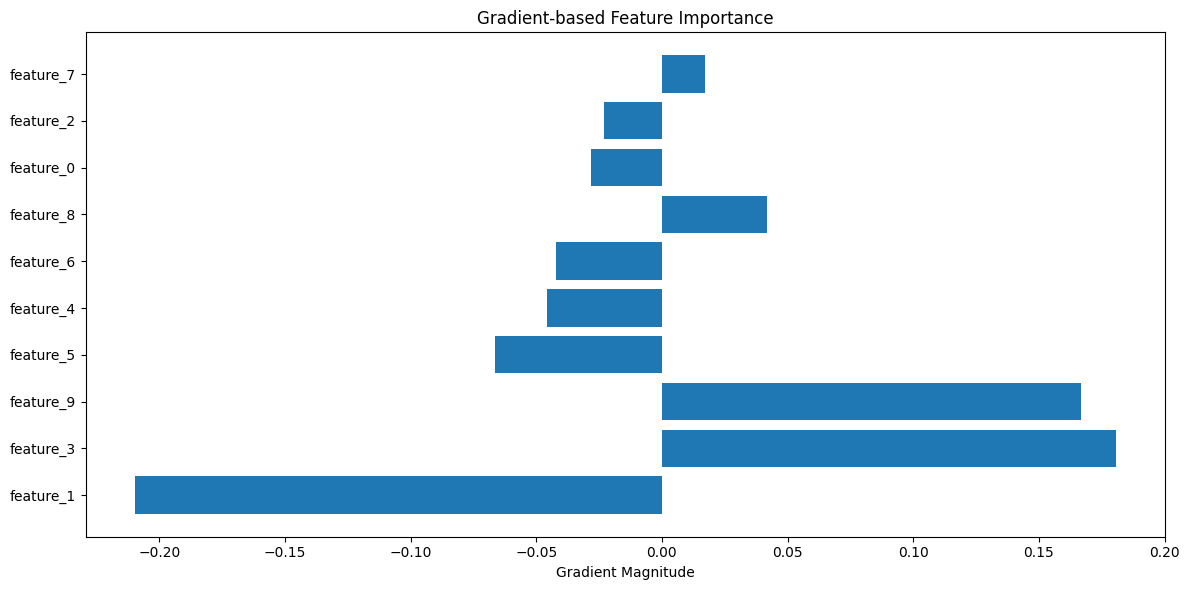


Sample 4: True: Fake, Predicted: Fake (0.5101)


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


LIME explanation failed: index 1 is out of bounds for axis 1 with size 1


100%|██████████| 1/1 [00:12<00:00, 12.05s/it]

SHAP explanation failed: 'numpy.float64' object is not iterable


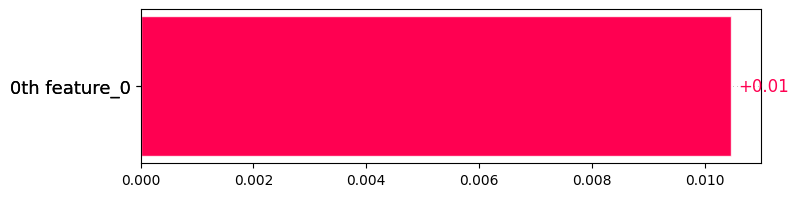

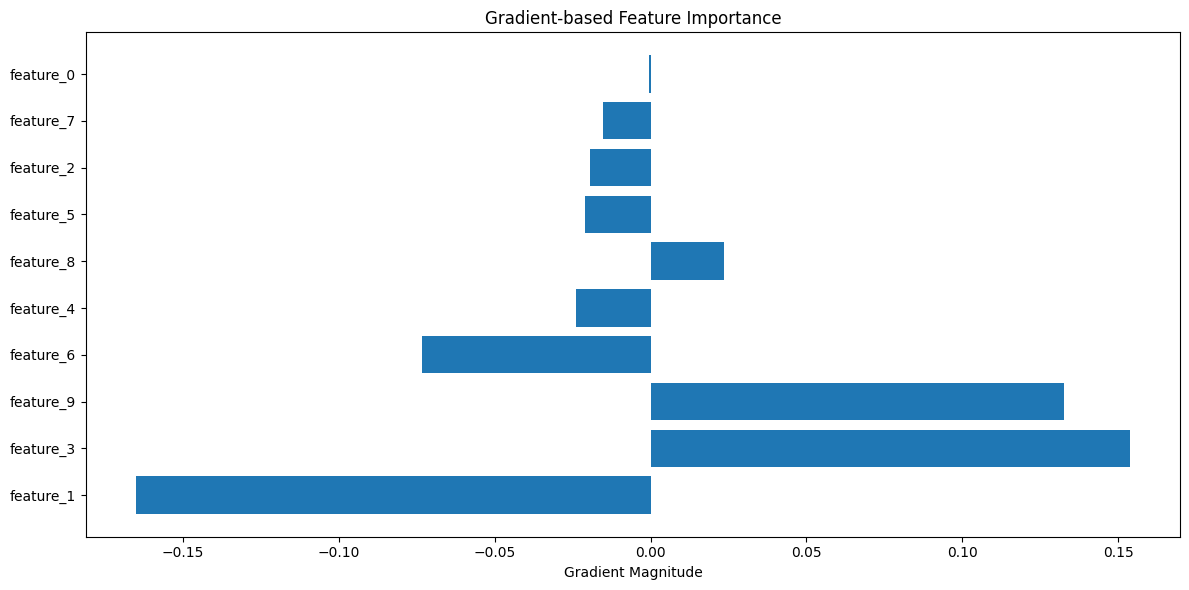


Sample 8: True: Real, Predicted: Real (0.5245)


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


LIME explanation failed: index 1 is out of bounds for axis 1 with size 1


100%|██████████| 1/1 [00:09<00:00,  9.98s/it]

SHAP explanation failed: 'numpy.float64' object is not iterable


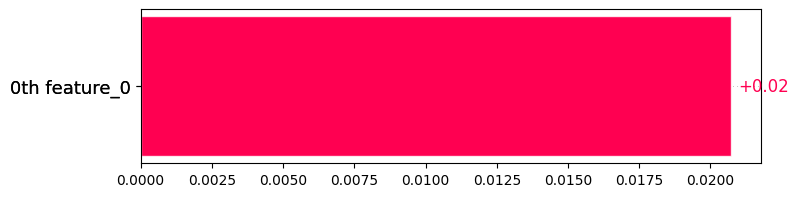

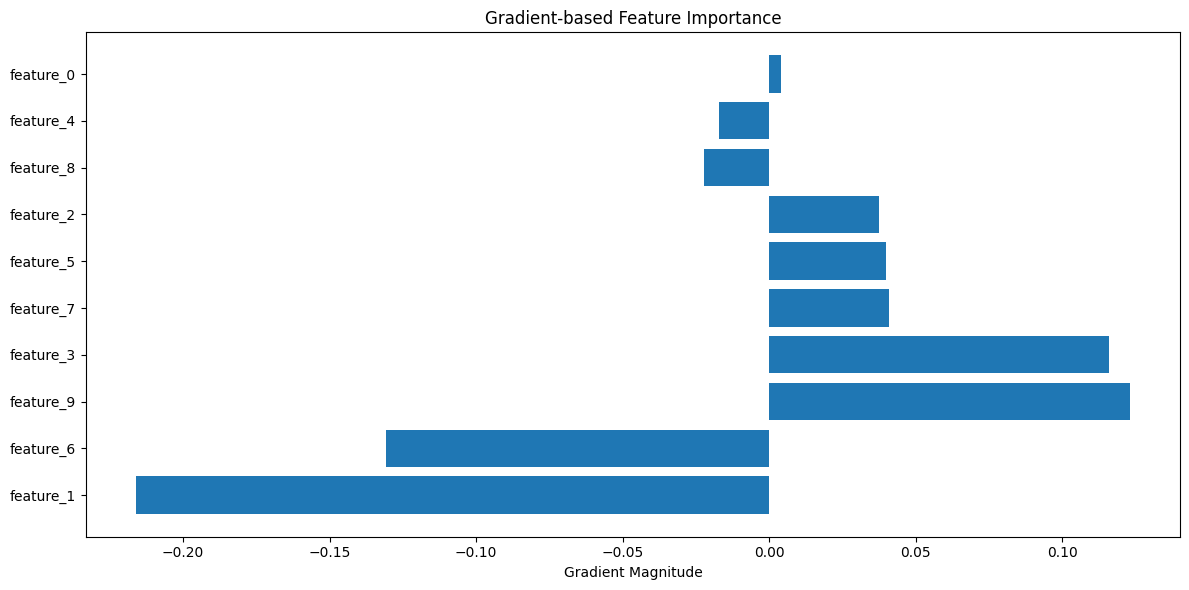

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import shap
import tensorflow as tf

def explain_with_lime(model, X_train, X_sample, feature_names, class_names=['Fake', 'Real']):
    """Explain model prediction using LIME"""
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        verbose=False
    )

    # Wrapper function to format predictions correctly for LIME
    def predict_proba(x):
        preds = model.predict(x, verbose=0)
        if preds.ndim == 1:  # Binary classification case
            return np.vstack([1-preds, preds]).T
        return preds  # Multi-class case

    explanation = explainer.explain_instance(
        X_sample,
        predict_fn=predict_proba,
        num_features=min(10, len(feature_names))
    )

    return explanation

def explain_with_shap(model, X_train, X_sample, feature_names):
    """Explain model prediction using SHAP"""
    # Wrapper function for SHAP
    def predict_fn(x):
        return model.predict(x, verbose=0)

    # Use KernelExplainer as more general purpose
    explainer = shap.KernelExplainer(
        predict_fn,
        shap.sample(X_train, 100)  # Use subset for background
    )

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_sample.reshape(1, -1))

    # Plot for binary classification
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Take values for positive class

    shap.plots.bar(shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
        feature_names=feature_names,
        data=X_sample
    ))

def grad_cam_like_explanation(model, sample, feature_names):
    """Gradient-based explanation similar to Grad-CAM"""
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        pred = model(sample_tensor)
        target = pred[:, 1] if pred.shape[1] == 2 else pred[0]  # Handle binary vs multi-class

    grads = tape.gradient(target, sample_tensor).numpy()[0]

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(np.abs(grads))[::-1]
    plt.barh(np.array(feature_names)[sorted_idx], grads[sorted_idx])
    plt.xlabel("Gradient Magnitude")
    plt.title("Gradient-based Feature Importance")
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Sample test data - replace with your actual data
    X_train = np.random.rand(100, 10)
    X_test = np.random.rand(10, 10)
    y_test = np.random.randint(0, 2, 10)
    feature_names = [f"feature_{i}" for i in range(10)]

    # Sample model - replace with your actual model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')

    # Test with random samples
    for i in np.random.choice(len(X_test), min(3, len(X_test)), replace=False):
        sample = X_test[i]
        pred = model.predict(sample[np.newaxis], verbose=0)

        # Handle both binary and categorical outputs
        if pred.shape[1] == 2:  # Categorical output
            pred_class = 'Real' if pred[0,1] > 0.5 else 'Fake'
            pred_prob = float(pred[0,1] if pred[0,1] > 0.5 else 1 - pred[0,1])
        else:  # Binary output
            pred_class = 'Real' if pred[0,0] > 0.5 else 'Fake'
            pred_prob = float(pred[0,0] if pred[0,0] > 0.5 else 1 - pred[0,0])

        true_class = 'Real' if y_test[i] == 1 else 'Fake'

        print(f"\nSample {i}: True: {true_class}, Predicted: {pred_class} ({pred_prob:.4f})")

        # LIME explanation
        try:
            lime_exp = explain_with_lime(model, X_train, sample, feature_names)
            lime_exp.show_in_notebook()
            print("\nTop contributing LIME features:")
            for feature, weight in lime_exp.as_list()[:5]:
                print(f"{feature}: {weight:.4f}")
        except Exception as e:
            print(f"LIME explanation failed: {str(e)}")

        # SHAP explanation
        try:
            explain_with_shap(model, X_train, sample, feature_names)
        except Exception as e:
            print(f"SHAP explanation failed: {str(e)}")

        # Gradient explanation
        try:
            grad_cam_like_explanation(model, sample, feature_names)
        except Exception as e:
            print(f"Gradient explanation failed: {str(e)}")

In [28]:
# Assuming you have feature_names stored somewhere
try:
    print("Model was trained on these features:")
    for i, feature in enumerate(feature_names):
        print(f"{i+1}. {feature}")
except NameError:
    print("Feature names not found in memory")

Model was trained on these features:
1. feature_0
2. feature_1
3. feature_2
4. feature_3
5. feature_4
6. feature_5
7. feature_6
8. feature_7
9. feature_8
10. feature_9


In [29]:
for i in np.random.choice(len(X_test), 3, replace=False):
    sample = X_test[i]
    pred = model.predict(sample[np.newaxis])[0][0]
    pred_class = 'Real' if pred > 0.5 else 'Fake'
    true_class = 'Real' if y_test[i] == 1 else 'Fake'

    print(f"\nSample {i}: True: {true_class}, Predicted: {pred_class} ({pred:.4f})")

    lime_exp = explain_with_lime(model, X_train, sample, feature_names)
    lime_exp.show_in_notebook()



    print("\nTop contributing LIME features:")
    for feature, weight in lime_exp.as_list()[:5]:
        print(f"{feature}: {weight:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step

Sample 5: True: Real, Predicted: Fake (0.4278)


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
import lime
import lime.lime_tabular
import numpy as np

# Create the prediction function that LIME expects (should output probabilities)
def predict_fn(X):
    return model.predict(X)  # Ensure model returns probabilities (not class predictions)

# Explain a random instance (can replace X_test[0] with any specific sample)
sample = X_test[0].reshape(1, -1)

# Create LIME explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=feature_names,
    class_names=['Fake', 'Real'],
    mode='classification'
)

# Explain the prediction for the given sample
lime_exp = explainer.explain_instance(sample[0], predict_fn, num_features=10)

# Show explanation in the notebook
lime_exp.show_in_notebook()


In [12]:
X, y, feature_names, scaler = load_dataset(data_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


NameError: name 'load_dataset' is not defined

In [21]:
import lime
from lime import lime_tabular
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import display, HTML



# Assuming your model is already loaded
# model = tf.keras.models.load_model('best_tabular_model.h5')
# X_scaled = np.load('X_scaled.npy')  # Data used for training
# feature_names = np.load('feature_names.npy')  # Features used for training
# y_labels = np.load('y_labels.npy')

# Adjust model prediction for LIME
def predict_fn_for_lime(X):
    predictions = model.predict(X)
    return np.column_stack([1 - predictions, predictions])  # [Fake, Real] probabilities

# Initialize LimeTabularExplainer for model explanation
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_scaled,
    feature_names=feature_names,  # No need for .tolist() here
    class_names=['Fake', 'Real'],
    mode='classification'
)

# Choose a sample to explain
sample = X_scaled[0]  # or any sample from X_scaled

# Explain the instance with LIME
lime_exp = explainer.explain_instance(sample, predict_fn_for_lime, num_features=10)

# Show LIME explanation
lime_exp.show_in_notebook()  # This will render the explanation in a Jupyter Notebook

# Optionally save LIME explanation as HTML
lime_exp.as_html()
with open("lime_explanation.html", "w", encoding="utf-8") as f:
    f.write(lime_exp.as_html())

# Open in a web browser
import webbrowser
webbrowser.open("lime_explanation.html")


NameError: name 'X_scaled' is not defined

In [2]:
import numpy as np
from lime import lime_tabular
import matplotlib.pyplot as plt

# Assume you already have these:
# X_scaled: scaled features (numpy array)
# model: your trained Keras or PyTorch model
# feature_names: list of feature names

# Predict function wrapper for LIME (output: [Fake, Real])
def predict_fn_for_lime(input_data):
    predictions = model.predict(input_data)
    return np.column_stack([1 - predictions, predictions])

# Initialize LimeTabularExplainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_scaled,
    feature_names=feature_names,
    class_names=['Fake', 'Real'],
    mode='classification'
)

# Explain the first sample
sample = X_scaled[0]
lime_exp = explainer.explain_instance(sample, predict_fn_for_lime, num_features=10)

# Display explanation in notebook or save to HTML
lime_exp.show_in_notebook()  # If Jupyter works
# with open("lime_explanation.html", "w") as f:
#     f.write(lime_exp.as_html())


NameError: name 'X_scaled' is not defined

In [44]:
!pip show ipython


Name: ipython
Version: 9.1.0
Summary: IPython: Productive Interactive Computing
Home-page: https://ipython.org
Author: The IPython Development Team
Author-email: ipython-dev@python.org
License: BSD-3-Clause
Location: C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages
Requires: colorama, decorator, ipython-pygments-lexers, jedi, matplotlib-inline, prompt_toolkit, pygments, stack_data, traitlets, typing_extensions
Required-by: ipykernel


In [46]:
!python --version


Python 3.11.6


In [1]:
!pip uninstall ipython
!pip install ipython


^C


In [39]:
from IPython.display import display


In [34]:
import lime
from lime import lime_tabular
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming your model is already loaded
# model = tf.keras.models.load_model('best_tabular_model.h5')
# X_scaled = np.load('X_scaled.npy')  # Data used for training
# feature_names = np.load('feature_names.npy')  # Features used for training
# y_labels = np.load('y_labels.npy')

# Adjust model prediction for LIME
def predict_fn_for_lime(X):
    predictions = model.predict(X)
    return np.column_stack([1 - predictions, predictions])  # [Fake, Real] probabilities

# Initialize LimeTabularExplainer for model explanation
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_scaled,
    feature_names=feature_names,  # No need for .tolist() here
    class_names=['Fake', 'Real'],
    mode='classification'
)

# Choose a sample to explain
sample = X_scaled[0]  # or any sample from X_scaled

# Explain the instance with LIME
lime_exp = explainer.explain_instance(sample, predict_fn_for_lime, num_features=10)

# Show LIME explanation
lime_exp.show_in_notebook()  # This will render the explanation in a Jupyter Notebook

# Optionally save LIME explanation as HTML
lime_exp.as_html()
with open("lime_explanation.html", "w", encoding="utf-8") as f:
    f.write(lime_exp.as_html())

# Open in a web browser
import webbrowser
webbrowser.open("lime_explanation.html")


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


ImportError: cannot import name 'display' from 'IPython.core.display' (C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\IPython\core\display.py)

In [22]:
import lime
import lime.lime_tabular
import numpy as np

# Create the prediction function that LIME expects (should output probabilities)
def predict_fn(X):
    return model.predict(X)  # Ensure model returns probabilities (not class predictions)

# Explain a random instance (can replace X_test[0] with any specific sample)
sample = X_test[0].reshape(1, -1)

# Create LIME explainer for tabular data
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=feature_names,
    class_names=['Fake', 'Real'],
    mode='classification'
)

# Explain the prediction for the given sample
lime_exp = explainer.explain_instance(sample[0], predict_fn, num_features=10)

# Show explanation in the notebook
lime_exp.show_in_notebook()


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


IndexError: index 1 is out of bounds for axis 1 with size 1

In [35]:
import IPython

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Top 10 LIME features:
mel_119_mean <= -0.80: 0.1041
mel_123_std <= -1.05: 0.0984
mel_117_mean <= -0.80: 0.0869
mel_127_std <= -1.04: 0.0854
spectral_contrast_7_mean > 0.96: 0.0774
mel_126_std <= -1.04: 0.0765
mel_120_mean <= -0.80: 0.0755
mel_125_std <= -1.04: 0.0698
mel_57_mean <= -0.57: -0.0595
-1.06 < mel_119_std <= -0.12: 0.0586


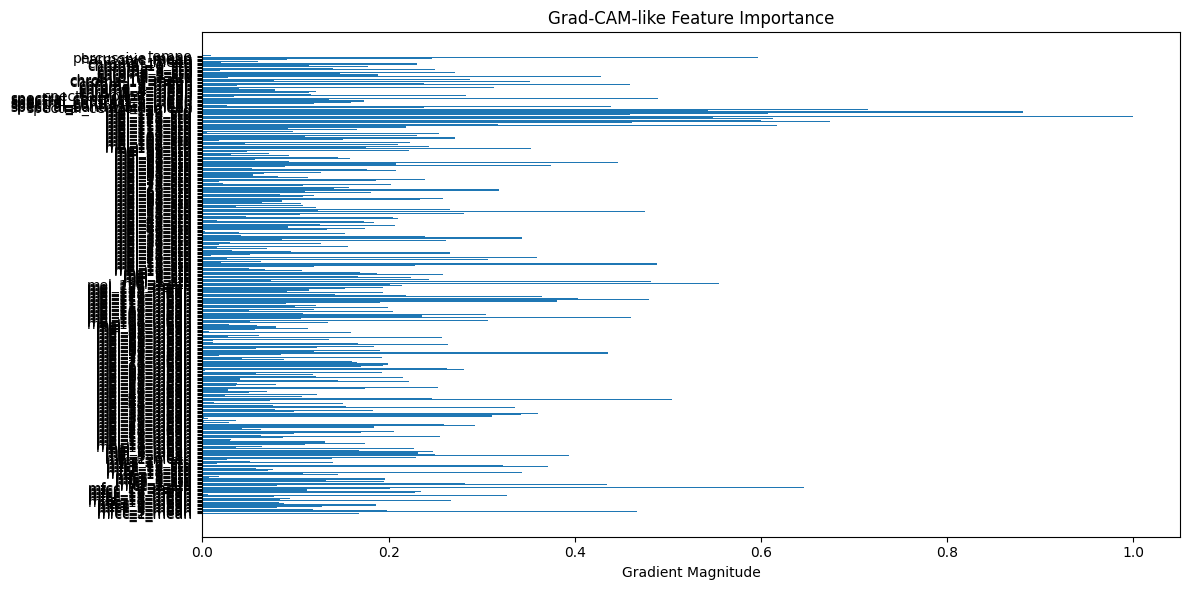

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model Accuracy: 100.00%


In [32]:
import numpy as np
import tensorflow as tf
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import webbrowser

# =========================
# 1. Define Feature Names
# =========================
def get_feature_names(n_mfcc=20, n_mels=128):
    feature_names = []

    # MFCC mean and std
    feature_names += [f"mfcc_{i+1}_mean" for i in range(n_mfcc)]
    feature_names += [f"mfcc_{i+1}_std" for i in range(n_mfcc)]

    # Mel spectrogram mean and std
    feature_names += [f"mel_{i+1}_mean" for i in range(n_mels)]
    feature_names += [f"mel_{i+1}_std" for i in range(n_mels)]

    # Spectral features
    feature_names.append("spectral_centroid_mean")
    feature_names.append("spectral_bandwidth_mean")
    feature_names += [f"spectral_contrast_{i+1}_mean" for i in range(7)]
    feature_names.append("spectral_rolloff_mean")

    # Chroma mean and std
    feature_names += [f"chroma_{i+1}_mean" for i in range(12)]
    feature_names += [f"chroma_{i+1}_std" for i in range(12)]

    # Other features
    feature_names.append("zcr_mean")
    feature_names.append("rms_mean")
    feature_names.append("harmonic_mean")
    feature_names.append("percussive_mean")
    feature_names.append("tempo")

    return feature_names

# =========================
# 2. Load Data and Model
# =========================
X_scaled = np.load('X_scaled.npy')
y_labels = np.load('y_labels.npy')
feature_names = get_feature_names()

model = tf.keras.models.load_model('best_tabular_model.h5')

# =========================
# 3. Prediction Function for LIME
# =========================
def predict_fn_for_lime(X):
    predictions = model.predict(X)
    return np.column_stack([1 - predictions, predictions])  # [Fake, Real] probabilities

# =========================
# 4. LIME Explanation
# =========================
explainer = LimeTabularExplainer(
    X_scaled,
    feature_names=feature_names,
    class_names=['Fake', 'Real'],
    mode='classification'
)

sample = X_scaled[0]
lime_exp = explainer.explain_instance(sample, predict_fn_for_lime, num_features=10)

# Save to HTML
with open("lime_explanation.html", "w", encoding="utf-8") as f:
    f.write(lime_exp.as_html())
webbrowser.open("lime_explanation.html")

# Optional: Print top features to console
print("\nTop 10 LIME features:")
for feature, weight in lime_exp.as_list():
    print(f"{feature}: {weight:.4f}")

# =========================
# 5. Grad-CAM-like Explanation
# =========================
def grad_cam_explanation(model, sample, feature_names):
    with tf.GradientTape() as tape:
        sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)
        tape.watch(sample_tensor)
        predictions = model(sample_tensor)

    grads = tape.gradient(predictions, sample_tensor).numpy().flatten()
    importance = np.abs(grads)
    importance = importance / (importance.max() + 1e-10)

    plt.figure(figsize=(12, 6))
    plt.barh(feature_names, importance)
    plt.xlabel("Gradient Magnitude")
    plt.title("Grad-CAM-like Feature Importance")
    plt.tight_layout()
    plt.show()

grad_cam_explanation(model, sample, feature_names)

# =========================
# 6. Evaluate Model
# =========================
y_pred = model.predict(X_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_labels, y_pred_classes)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")


In [21]:
!pip install ipython

In [22]:
np.save('X_scaled.npy', X)
np.save('y_labels.npy', y)
np.save('feature_names.npy', np.array(feature_names))


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from lime import lime_tabular
import shap
import matplotlib.pyplot as plt

# ========================
# Load Saved Data
# ========================
X = np.load('X_scaled.npy')
y = np.load('y_labels.npy')
feature_names = np.load('feature_names.npy', allow_pickle=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========================
# Recreate the Model
# ========================
def create_tabular_model(input_shape):
    model = models.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_tabular_model(X_train.shape[1])
callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
             ModelCheckpoint('best_tabular_model.h5', save_best_only=True)]

model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=callbacks, verbose=1)
model = models.load_model('best_tabular_model.h5')

# ========================
# Explanation Functions
# ========================
def explain_with_lime(model, X_train, X_sample, feature_names):
    explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names,
                                                  class_names=['Fake', 'Real'], mode='classification')
    explanation = explainer.explain_instance(X_sample, model.predict, num_features=10)

    import webbrowser
    html_path = "lime_explanation.html"
    with open(html_path, "w") as f:
        f.write(explanation.as_html())
    webbrowser.open(html_path)
    return explanation

def explain_with_shap(model, X_train, X_sample, feature_names):
    explainer = shap.DeepExplainer(model, X_train[:100])
    shap_values = explainer.shap_values(np.array([X_sample]))[0][0]
    plt.figure(figsize=(12, 5))
    shap.bar_plot(shap_values, feature_names=feature_names)
    plt.tight_layout()
    plt.show()

def grad_cam_like_explanation(model, sample, feature_names):
    import tensorflow as tf
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        pred = model(sample_tensor)
    grads = tape.gradient(pred, sample_tensor).numpy()[0]

    plt.figure(figsize=(12, 5))
    plt.barh(feature_names, grads)
    plt.xlabel("Gradient")
    plt.title("Grad-CAM Style Input Gradient Importance")
    plt.tight_layout()
    plt.show()

# ========================
# Predict and Explain
# ========================
for i in np.random.choice(len(X_test), 3, replace=False):
    sample = X_test[i]
    pred = model.predict(sample[np.newaxis])[0][0]
    pred_class = 'Real' if pred > 0.5 else 'Fake'
    true_class = 'Real' if y_test[i] == 1 else 'Fake'

    print(f"\nSample {i}: True: {true_class}, Predicted: {pred_class} ({pred:.4f})")

    lime_exp = explain_with_lime(model, X_train, sample, feature_names)
    explain_with_shap(model, X_train, sample, feature_names)
    grad_cam_like_explanation(model, sample, feature_names)

    print("\nTop contributing LIME features:")
    for feature, weight in lime_exp.as_list()[:5]:
        print(f"{feature}: {weight:.4f}")


Epoch 1/50
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9018 - loss: 0.2334

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9037 - loss: 0.2297 - val_accuracy: 1.0000 - val_loss: 0.0111
Epoch 2/50
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0106

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 3/50
54/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0028

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 4/50
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0031

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 2.7491e-04
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 3.3976e-04
Epoch 6/50
55/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0016

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 1.3763e-04
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 2.3694e-04
Epoch 8/50
55/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 1.0339e-04
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2990e-04 - val_accuracy: 1.0000 - val_loss: 1.2037e-04
Epoch 10/50
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8880e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.2496e-04 - val_accuracy: 1.0000 - val_loss: 8.4502e-05
Epoch 11/50
59/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 2.7583e-05
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6387e-04 - val_accuracy: 1.0000 - val_loss: 4.0475e-05
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.8660e-04 - val_accuracy: 1.0000 - val_loss: 4.1874e-05
Epoch 14/50
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.4887e-04

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.4420e-04 - val_accuracy: 1.0000 - val_loss: 2.0841e-05
Epoch 15/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1833e-04 - val_accuracy: 1.0000 - val_loss: 2.2038e-05
Epoch 16/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.5797e-04 - val_accuracy: 1.0000 - val_loss: 4.4508e-05
Epoch 17/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.8793e-04 - val_accuracy: 1.0000 - val_loss: 2.1586e-05
Epoch 18/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.9019e-05 - val_accuracy: 1.0000 - val_loss: 2.8634e-05
Epoch 19/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.1916e-05 - val_accuracy: 1.0000 - val_loss: 2.6320e-05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step

Sample 654: True: Fake, Predicted: Fake (0.0000)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


IndexError: index 1 is out of bounds for axis 1 with size 1

In [24]:
import numpy as np
import tensorflow as tf
from lime import lime_tabular
import shap
import matplotlib.pyplot as plt
import random

# ========== Load Data and Model ==========
X = np.load('X_scaled.npy')
y = np.load('y_labels.npy')
feature_names = np.load('feature_names.npy', allow_pickle=True)
model = tf.keras.models.load_model('best_tabular_model.h5')

# ========== Choose Random Sample ==========
sample_idx = random.randint(0, len(X) - 1)
sample = X[sample_idx]
true_label = y[sample_idx]
pred_prob = model.predict(sample[np.newaxis])[0][0]
pred_class = 'Real' if pred_prob > 0.5 else 'Fake'
true_class = 'Real' if true_label == 1 else 'Fake'

print(f"\nSample {sample_idx}: True: {true_class}, Predicted: {pred_class} ({pred_prob:.4f})")

# ========== LIME Explanation ==========
explainer = lime_tabular.LimeTabularExplainer(
    X, feature_names=feature_names.tolist(), class_names=['Fake', 'Real'], mode='classification'
)
lime_exp = explainer.explain_instance(sample, model.predict, num_features=10)

# Save LIME output to HTML and open in browser
import webbrowser
with open("lime_explanation.html", "w") as f:
    f.write(lime_exp.as_html())
webbrowser.open("lime_explanation.html")

# ========== SHAP Explanation ==========
explainer_shap = shap.DeepExplainer(model, X[:100])  # subset of background data
shap_values = explainer_shap.shap_values(np.array([sample]))[0][0]

plt.figure(figsize=(12, 5))
shap.bar_plot(shap_values, feature_names=feature_names.tolist())
plt.title("SHAP Feature Contributions")
plt.tight_layout()
plt.show()

# ========== Grad-CAM-Like Explanation ==========
sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(sample_tensor)
    pred = model(sample_tensor)

grads = tape.gradient(pred, sample_tensor).numpy()[0]

plt.figure(figsize=(12, 5))
plt.barh(feature_names, grads)
plt.xlabel("Gradient")
plt.title("Grad-CAM Style Input Gradient Importance")
plt.tight_layout()
plt.show()

# ========== Top LIME Features ==========
print("\nTop contributing LIME features:")
for feature, weight in lime_exp.as_list()[:5]:
    print(f"{feature}: {weight:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step

Sample 1941: True: Fake, Predicted: Fake (0.0000)
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


IndexError: index 1 is out of bounds for axis 1 with size 1

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import lime
from lime import lime_tabular
import shap
import tensorflow as tf

# ========================
# EXPLANATION FUNCTIONS
# ========================

def explain_with_lime(model, X_train, X_sample, feature_names, class_names=['Fake', 'Real']):
    """Generate LIME explanation for a single sample"""
    # Create custom predict function for LIME compatibility
    def predict_proba(x):
        return np.hstack((1 - model.predict(x, verbose=0), model.predict(x, verbose=0)))

    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        verbose=False
    )

    explanation = explainer.explain_instance(
        data_row=X_sample,
        predict_fn=predict_proba,
        num_features=10
    )

    return explanation

def explain_with_shap(model, X_train, X_sample, feature_names):
    """Generate SHAP explanation for a single sample"""
    # Use subset of training data as background
    background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

    # Create SHAP explainer
    explainer = shap.DeepExplainer(
        model=model,
        data=background
    )

    # Calculate SHAP values
    shap_values = explainer.shap_values(np.array([X_sample]))[0][0]

    # Plot results
    plt.figure(figsize=(12, 5))
    shap.bar_plot(
        shap_values=shap_values,
        feature_names=feature_names,
        max_display=15
    )
    plt.title("SHAP Feature Contributions")
    plt.tight_layout()
    plt.show()

def grad_cam_like_explanation(model, sample, feature_names):
    """Generate gradient-based explanation similar to Grad-CAM"""
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        prediction = model(sample_tensor)

    gradients = tape.gradient(prediction, sample_tensor).numpy()[0]

    # Plot gradients
    plt.figure(figsize=(12, 5))
    plt.barh(feature_names, gradients)
    plt.xlabel("Gradient Magnitude")
    plt.title("Input Gradient Importance")
    plt.tight_layout()
    plt.show()

# ========================
# MAIN EXECUTION
# ========================
if __name__ == "__main__":
    # Load preprocessed data and trained model
    model = tf.keras.models.load_model('best_tabular_model.h5')
    X_scaled = np.load('preprocessed_features.npy')  # Assuming saved preprocessing
    y = np.load('labels.npy')
    feature_names = np.load('feature_names.npy')

    # Split data (if not already saved)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Explain 3 random samples
    for i in np.random.choice(len(X_test), 3, replace=False):
        sample = X_test[i]
        pred_prob = model.predict(sample[np.newaxis])[0][0]
        pred_class = 'Real' if pred_prob > 0.5 else 'Fake'
        true_class = 'Real' if y_test[i] == 1 else 'Fake'

        print(f"\nSample {i}:")
        print(f"True: {true_class}, Predicted: {pred_class} ({pred_prob:.4f})")

        # Generate explanations
        lime_exp = explain_with_lime(model, X_train, sample, feature_names)
        lime_exp.show_in_notebook()

        explain_with_shap(model, X_train, sample, feature_names)

        grad_cam_like_explanation(model, sample, feature_names)

        # Show LIME feature weights
        print("\nTop LIME Features:")
        for feat, weight in lime_exp.as_list()[:10]:
            print(f"{feat}: {weight:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'preprocessed_features.npy'

In [25]:
import numpy as np
import random
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from lime import lime_tabular
from tensorflow.keras import backend as K
import librosa.display
import os

# Load the saved data
X = np.load('X_scaled.npy')
y = np.load('y_labels.npy')
feature_names = np.load('feature_names.npy', allow_pickle=True)

# Load the trained model
model = tf.keras.models.load_model('best_tabular_model.h5')

# ========== Modify the predict function for LIME ==========
def predict_fn(x):
    # Ensure the model returns probabilities for both classes (Fake, Real)
    return np.array([model.predict(x)[:, 0], 1 - model.predict(x)[:, 0]]).T

# ========== Choose Random Sample ==========
sample_idx = random.randint(0, len(X) - 1)
sample = X[sample_idx]
true_label = y[sample_idx]
pred_prob = model.predict(sample[np.newaxis])[0][0]
pred_class = 'Real' if pred_prob > 0.5 else 'Fake'
true_class = 'Real' if true_label == 1 else 'Fake'

print(f"\nSample {sample_idx}: True: {true_class}, Predicted: {pred_class} ({pred_prob:.4f})")

# ========== LIME Explanation ==========
explainer = lime_tabular.LimeTabularExplainer(
    X, feature_names=feature_names.tolist(), class_names=['Fake', 'Real'], mode='classification'
)

lime_exp = explainer.explain_instance(sample, predict_fn, num_features=10)

# Save LIME output to HTML and open in browser
import webbrowser
with open("lime_explanation.html", "w") as f:
    f.write(lime_exp.as_html())
webbrowser.open("lime_explanation.html")


# ========== SHAP Explanation ==========
# Initialize SHAP explainer using the model
explainer_shap = shap.KernelExplainer(predict_fn, X)

# Compute SHAP values for the sample
shap_values = explainer_shap.shap_values(sample)

# Plot SHAP values
shap.initjs()
shap.summary_plot(shap_values, X, feature_names=feature_names.tolist())

# Save SHAP plot as an image
shap.summary_plot(shap_values, X, feature_names=feature_names.tolist(), show=False)
plt.savefig('shap_summary_plot.png')

# ========== Grad-CAM Explanation (Placeholder) ==========
# Since Grad-CAM typically works on convolutional neural networks (CNNs) for visual tasks,
# it's not directly applicable to your tabular data model, as it's used for interpreting
# deep learning models on image classification tasks. However, you can apply Grad-CAM
# to models that use CNNs with image-based inputs.
# If you plan to use Grad-CAM on audio data transformed to spectrograms, here's an approach.

# Placeholder for Grad-CAM explanation (if you modify the model to use CNN)
def grad_cam(model, X, layer_name='conv2d'):
    # Convert the sample to a tensor and compute the gradients
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(X)
        tape.watch(inputs)
        layer_output, predictions = grad_model(inputs)
    grads = tape.gradient(predictions, layer_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Generate Grad-CAM heatmap
    heatmap = layer_output[0].numpy() @ pooled_grads.numpy()
    heatmap = np.mean(heatmap, axis=-1)

    plt.imshow(heatmap, cmap='jet')
    plt.colorbar()
    plt.show()

# This Grad-CAM implementation is placeholder code. You can modify your model to include
# convolutional layers and then use Grad-CAM on the audio features by transforming them
# into spectrograms, for example.

# Example of Grad-CAM usage (if applicable, with convolutional layers)
# grad_cam(model, sample[np.newaxis])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step

Sample 2472: True: Fake, Predicted: Fake (0.0000)
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


UnicodeEncodeError: 'charmap' codec can't encode character '\u03b5' in position 59564: character maps to <undefined>

In [20]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import lime
from lime import lime_tabular
import shap

# ========================
# FEATURE EXTRACTION
# ========================
def extract_features(file_path, n_mfcc=20, n_mels=128):
    y, sr = librosa.load(file_path, sr=22050)
    features = []

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    features.append(np.mean(mfcc, axis=1))
    features.append(np.std(mfcc, axis=1))

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel)
    features.append(np.mean(mel_db, axis=1))
    features.append(np.std(mel_db, axis=1))

    features.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1))
    features.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.append(np.mean(chroma, axis=1))
    features.append(np.std(chroma, axis=1))

    features.append(np.mean(librosa.feature.zero_crossing_rate(y)))
    features.append(np.mean(librosa.feature.rms(y=y)))

    y_harmonic, y_percussive = librosa.effects.hpss(y)
    features.append(np.mean(y_harmonic))
    features.append(np.mean(y_percussive))

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features.append(tempo)

    return np.hstack(features)

# ========================
# LOAD DATA
# ========================
def load_dataset(data_path):
    X, y = [], []
    dummy_path = os.path.join(data_path, 'Real', 'real_1.wav')
    feature_names = [f"feature_{i}" for i in range(len(extract_features(dummy_path)))]

    for label in ['Real', 'Fake']:
        class_path = os.path.join(data_path, label)
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                path = os.path.join(class_path, file)
                X.append(extract_features(path))
                y.append(label)

    X = np.array(X)
    y = LabelEncoder().fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, feature_names, scaler

# ========================
# EXPLANATION FUNCTIONS
# ========================
def explain_with_lime(model, X_train, X_sample, feature_names, class_names=['Fake', 'Real']):
    def predict_proba(x):
        return np.hstack((1 - model.predict(x, verbose=0), model.predict(x, verbose=0)))

    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )

    return explainer.explain_instance(X_sample, predict_fn=predict_proba, num_features=10)

def explain_with_shap(model, X_train, X_sample, feature_names):
    background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
    explainer = shap.DeepExplainer(model, background)
    shap_values = explainer.shap_values(np.array([X_sample]))[0][0]

    plt.figure(figsize=(12, 5))
    shap.bar_plot(shap_values=shap_values, feature_names=feature_names, max_display=15)
    plt.title("SHAP Feature Contributions")
    plt.tight_layout()
    plt.show()

def grad_cam_like_explanation(model, sample, feature_names):
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        prediction = model(sample_tensor)
    gradients = tape.gradient(prediction, sample_tensor).numpy()[0]

    plt.figure(figsize=(12, 5))
    plt.barh(feature_names, gradients)
    plt.xlabel("Gradient Magnitude")
    plt.title("Input Gradient Importance")
    plt.tight_layout()
    plt.show()

# ========================
# MAIN EXECUTION
# ========================
if __name__ == "__main__":
    data_path = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
    X, y, feature_names, _ = load_dataset(data_path)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = tf.keras.models.load_model('best_tabular_model.h5')

    for i in np.random.choice(len(X_test), 3, replace=False):
        sample = X_test[i]
        pred_prob = model.predict(sample[np.newaxis])[0][0]
        pred_class = 'Real' if pred_prob > 0.5 else 'Fake'
        true_class = 'Real' if y_test[i] == 1 else 'Fake'

        print(f"\nSample {i}:")
        print(f"True: {true_class}, Predicted: {pred_class} ({pred_prob:.4f})")

        lime_exp = explain_with_lime(model, X_train, sample, feature_names)
        lime_exp.show_in_notebook()

        explain_with_shap(model, X_train, sample, feature_names)
        grad_cam_like_explanation(model, sample, feature_names)

        print("\nTop LIME Features:")
        for feat, weight in lime_exp.as_list()[:10]:
            print(f"{feat}: {weight:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step

Sample 303:
True: Real, Predicted: Real (1.0000)


ImportError: cannot import name 'display' from 'IPython.core.display' (C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\IPython\core\display.py)

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.metrics import accuracy_score
import webbrowser

# Load the data
X_scaled = np.load('X_scaled.npy')
y_labels = np.load('y_labels.npy')
feature_names = np.load('feature_names.npy')

# Load the trained model (update the path to 'best_tabular_model.h5')
model = tf.keras.models.load_model('best_tabular_model.h5')

# ========== LIME Explanation ==========
# Initialize the LimeTabularExplainer
explainer = LimeTabularExplainer(
    X_scaled, feature_names=feature_names.tolist(),
    class_names=['Fake', 'Real'], mode='classification'
)

# Choose a sample for explanation (index 0 for this example)
sample = X_scaled[0]

# Explain the instance with LIME
lime_exp = explainer.explain_instance(sample, model.predict, num_features=10)

# Save LIME output to HTML with UTF-8 encoding
with open("lime_explanation.html", "w", encoding="utf-8") as f:
    f.write(lime_exp.as_html())
webbrowser.open("lime_explanation.html")

# ========== SHAP Explanation ==========
# Initialize SHAP explainer using the model
shap_explainer = shap.KernelExplainer(model.predict, X_scaled)
shap_values = shap_explainer.shap_values(X_scaled)

# Plot SHAP summary plot
shap.summary_plot(shap_values[1], X_scaled, feature_names=feature_names.tolist(), plot_type="bar")

# ========== Grad-CAM-like Explanation ==========
# Create Grad-CAM-like visual explanation (for tabular data)
# Grad-CAM is typically used for CNNs with image data, so here we use the concept for feature importance
def grad_cam_explanation(model, sample):
    # Get gradients of output w.r.t. input features
    with tf.GradientTape() as tape:
        sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)
        tape.watch(sample_tensor)
        predictions = model(sample_tensor)

    # Calculate gradients
    grads = tape.gradient(predictions, sample_tensor)

    # Get absolute gradients (this can be adjusted for different types of explanations)
    abs_grads = np.abs(grads.numpy())

    # Visualize the feature importance
    feature_importance = abs_grads.flatten()
    feature_importance = feature_importance / np.max(feature_importance)  # Normalize

    # Plot Grad-CAM-like explanation (feature importance)
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.xlabel('Features')
    plt.ylabel('Feature Importance (Gradient Magnitude)')
    plt.title('Grad-CAM-like Explanation (Feature Importance)')
    plt.show()

# Call Grad-CAM-like explanation for the first sample
grad_cam_explanation(model, sample)

# ========= Evaluating Model Performance =========
y_pred = model.predict(X_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming binary classification
accuracy = accuracy_score(y_labels, y_pred_classes)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


IndexError: index 1 is out of bounds for axis 1 with size 1

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.metrics import accuracy_score
import webbrowser

# Load the data
X_scaled = np.load('X_scaled.npy')
y_labels = np.load('y_labels.npy')
feature_names = np.load('feature_names.npy')

# Load the trained model (update the path to 'best_tabular_model.h5')
model = tf.keras.models.load_model('best_tabular_model.h5')

# Function to adjust the model's output to match LIME expectations for binary classification
def predict_fn_for_lime(X):
    # Get model predictions
    predictions = model.predict(X)

    # For binary classification, convert to 2D output with probabilities for both classes
    return np.column_stack([1 - predictions, predictions])  # [Fake, Real] probabilities

# ========== LIME Explanation ==========
# Initialize the LimeTabularExplainer
explainer = LimeTabularExplainer(
    X_scaled, feature_names=feature_names.tolist(),
    class_names=['Fake', 'Real'], mode='classification'
)

# Choose a sample for explanation (index 0 for this example)
sample = X_scaled[0]

# Explain the instance with LIME using adjusted predict_fn
lime_exp = explainer.explain_instance(sample, predict_fn_for_lime, num_features=10)

# Save LIME output to HTML with UTF-8 encoding
with open("lime_explanation.html", "w", encoding="utf-8") as f:
    f.write(lime_exp.as_html())
webbrowser.open("lime_explanation.html")

# ========== SHAP Explanation ==========
# Initialize SHAP explainer using the model
shap_explainer = shap.KernelExplainer(model.predict, X_scaled)
shap_values = shap_explainer.shap_values(X_scaled)

# Plot SHAP summary plot
shap.summary_plot(shap_values[1], X_scaled, feature_names=feature_names.tolist(), plot_type="bar")

# ========== Grad-CAM-like Explanation ==========
# Create Grad-CAM-like visual explanation (for tabular data)
def grad_cam_explanation(model, sample):
    # Get gradients of output w.r.t. input features
    with tf.GradientTape() as tape:
        sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)
        tape.watch(sample_tensor)
        predictions = model(sample_tensor)

    # Calculate gradients
    grads = tape.gradient(predictions, sample_tensor)

    # Get absolute gradients (this can be adjusted for different types of explanations)
    abs_grads = np.abs(grads.numpy())

    # Visualize the feature importance
    feature_importance = abs_grads.flatten()
    feature_importance = feature_importance / np.max(feature_importance)  # Normalize

    # Plot Grad-CAM-like explanation (feature importance)
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.xlabel('Features')
    plt.ylabel('Feature Importance (Gradient Magnitude)')
    plt.title('Grad-CAM-like Explanation (Feature Importance)')
    plt.show()

# Call Grad-CAM-like explanation for the first sample
grad_cam_explanation(model, sample)

# ========= Evaluating Model Performance =========
y_pred = model.predict(X_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming binary classification
accuracy = accuracy_score(y_labels, y_pred_classes)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 0/3600 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/3600 [00:00<?, ?it/s]


MemoryError: Unable to allocate 24.4 GiB for an array with shape (2718, 1206000) and data type float64

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


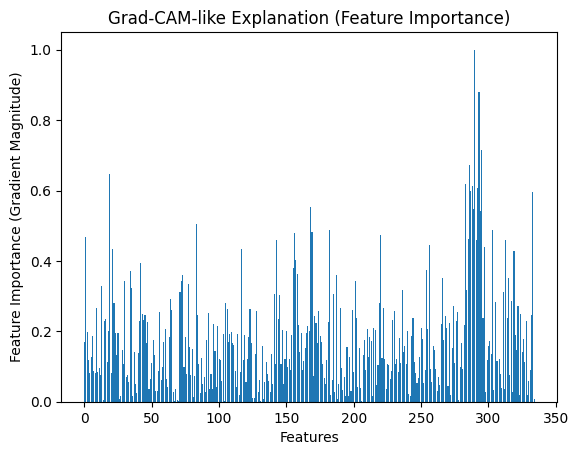

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Accuracy: 100.00%


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


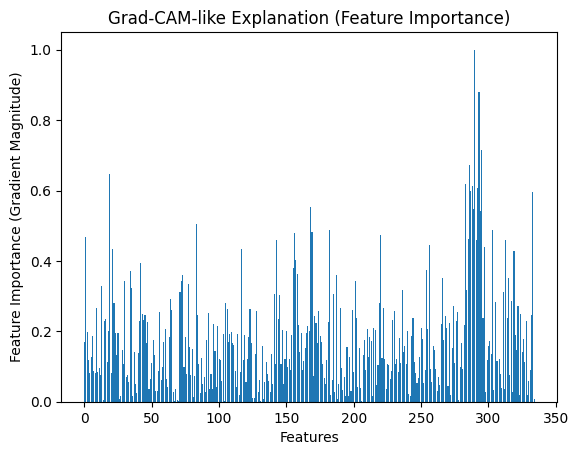

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Accuracy: 100.00%


In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.metrics import accuracy_score
import webbrowser

# Load the data
X_scaled = np.load('X_scaled.npy')
y_labels = np.load('y_labels.npy')
feature_names = np.load('feature_names.npy')

# Load the trained model
model = tf.keras.models.load_model('best_tabular_model.h5')

# Function to adjust the model's output to match LIME expectations for binary classification
def predict_fn_for_lime(X):
    predictions = model.predict(X)
    return np.column_stack([1 - predictions, predictions])  # [Fake, Real] probabilities

# ========== LIME Explanation ==========
# Initialize the LimeTabularExplainer
explainer = LimeTabularExplainer(
    X_scaled, feature_names=feature_names.tolist(),
    class_names=['Fake', 'Real'], mode='classification'
)

# Choose a sample for explanation (index 0 for this example)
sample = X_scaled[0]

# Explain the instance with LIME using adjusted predict_fn
lime_exp = explainer.explain_instance(sample, predict_fn_for_lime, num_features=10)

# Save LIME output to HTML
with open("lime_explanation.html", "w", encoding="utf-8") as f:
    f.write(lime_exp.as_html())
webbrowser.open("lime_explanation.html")

# ========== Grad-CAM-like Explanation ==========
def grad_cam_explanation(model, sample):
    # Get gradients of output w.r.t. input features
    with tf.GradientTape() as tape:
        sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)
        tape.watch(sample_tensor)
        predictions = model(sample_tensor)

    # Calculate gradients
    grads = tape.gradient(predictions, sample_tensor)
    abs_grads = np.abs(grads.numpy())

    # Visualize the feature importance
    feature_importance = abs_grads.flatten()
    feature_importance = feature_importance / np.max(feature_importance)

    plt.bar(range(len(feature_importance)), feature_importance)
    plt.xlabel('Features')
    plt.ylabel('Feature Importance (Gradient Magnitude)')
    plt.title('Grad-CAM-like Explanation (Feature Importance)')
    plt.show()

# Call Grad-CAM-like explanation
grad_cam_explanation(model, sample)

# ========= Evaluating Model Performance =========
y_pred = model.predict(X_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_labels, y_pred_classes)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


In [29]:
import shap
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming you have your model and data (X_scaled) already
# If you're using a deep learning model, ensure it's loaded and compiled

# Step 1: Downsample the background dataset (Optional)
# You can use k-means to summarize the data or shap.sample() to downsample
background_data = shap.kmeans(X_scaled, 100)  # Using 100 representative samples

# Step 2: Initialize the SHAP explainer with the downsampled background data
shap_explainer = shap.KernelExplainer(model.predict, background_data)

# Step 3: Compute SHAP values on a subset of your data to avoid memory overload
# If you need to explain more instances, consider splitting the dataset
shap_values = shap_explainer.shap_values(X_scaled[:100])  # Only explain the first 100 samples

# Step 4: Plot SHAP summary plot
shap.summary_plot(shap_values[1], X_scaled[:100], feature_names=feature_names.tolist(), plot_type="bar")

# Optional: If your model is tree-based, consider switching to TreeExplainer for efficiency
# If using tree-based models (like XGBoost or LightGBM):
# shap_explainer = shap.TreeExplainer(model)
# shap_values = shap_explainer.shap_values(X_scaled[:100])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


  1%|          | 1/100 [00:18<30:26, 18.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


  2%|▏         | 2/100 [00:37<31:09, 19.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


  3%|▎         | 3/100 [00:56<30:41, 18.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


  4%|▍         | 4/100 [01:17<31:27, 19.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


  5%|▌         | 5/100 [01:38<32:01, 20.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


  6%|▌         | 6/100 [01:52<28:14, 18.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


  7%|▋         | 7/100 [02:07<26:23, 17.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


  8%|▊         | 8/100 [02:25<26:32, 17.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


  9%|▉         | 9/100 [02:40<25:08, 16.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


 10%|█         | 10/100 [02:57<24:57, 16.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 11%|█         | 11/100 [03:14<25:01, 16.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 12%|█▏        | 12/100 [03:34<26:02, 17.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 13%|█▎        | 13/100 [03:49<24:49, 17.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


 14%|█▍        | 14/100 [04:05<23:39, 16.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 15%|█▌        | 15/100 [04:20<22:56, 16.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 16%|█▌        | 16/100 [04:38<23:13, 16.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 17%|█▋        | 17/100 [05:01<25:46, 18.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


 18%|█▊        | 18/100 [05:19<25:08, 18.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 19%|█▉        | 19/100 [05:39<25:22, 18.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 20%|██        | 20/100 [05:55<24:15, 18.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


 21%|██        | 21/100 [06:16<24:51, 18.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 22%|██▏       | 22/100 [06:35<24:34, 18.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 23%|██▎       | 23/100 [06:54<24:29, 19.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 24%|██▍       | 24/100 [07:14<24:27, 19.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 25%|██▌       | 25/100 [07:30<22:57, 18.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 26%|██▌       | 26/100 [07:50<23:05, 18.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 27%|██▋       | 27/100 [08:08<22:37, 18.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 28%|██▊       | 28/100 [08:26<22:03, 18.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 29%|██▉       | 29/100 [08:45<21:52, 18.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 30%|███       | 30/100 [09:04<21:54, 18.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 31%|███       | 31/100 [09:21<21:01, 18.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 32%|███▏      | 32/100 [09:38<20:05, 17.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 33%|███▎      | 33/100 [09:56<19:58, 17.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


 34%|███▍      | 34/100 [10:13<19:22, 17.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 35%|███▌      | 35/100 [10:29<18:38, 17.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 36%|███▌      | 36/100 [10:45<17:55, 16.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 37%|███▋      | 37/100 [11:03<17:51, 17.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


 38%|███▊      | 38/100 [11:19<17:30, 16.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 39%|███▉      | 39/100 [11:35<16:48, 16.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


 40%|████      | 40/100 [11:50<16:08, 16.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 41%|████      | 41/100 [12:07<16:11, 16.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 42%|████▏     | 42/100 [12:25<16:07, 16.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 43%|████▎     | 43/100 [12:41<15:40, 16.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 44%|████▍     | 44/100 [12:57<15:20, 16.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 45%|████▌     | 45/100 [13:14<15:16, 16.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 46%|████▌     | 46/100 [13:34<15:59, 17.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 47%|████▋     | 47/100 [13:56<16:41, 18.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


 48%|████▊     | 48/100 [14:13<15:53, 18.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 49%|████▉     | 49/100 [14:30<15:11, 17.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 50%|█████     | 50/100 [14:47<14:37, 17.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 51%|█████     | 51/100 [15:04<14:10, 17.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 52%|█████▏    | 52/100 [15:19<13:30, 16.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 53%|█████▎    | 53/100 [15:37<13:21, 17.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 54%|█████▍    | 54/100 [15:53<12:54, 16.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 55%|█████▌    | 55/100 [16:10<12:36, 16.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 56%|█████▌    | 56/100 [16:26<12:09, 16.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 57%|█████▋    | 57/100 [16:43<12:01, 16.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


 58%|█████▊    | 58/100 [16:59<11:39, 16.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 59%|█████▉    | 59/100 [17:17<11:28, 16.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 60%|██████    | 60/100 [17:33<11:05, 16.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 61%|██████    | 61/100 [17:49<10:46, 16.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 62%|██████▏   | 62/100 [18:08<10:59, 17.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 63%|██████▎   | 63/100 [18:26<10:40, 17.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 64%|██████▍   | 64/100 [18:44<10:34, 17.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 65%|██████▌   | 65/100 [19:02<10:20, 17.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


 66%|██████▌   | 66/100 [19:19<09:52, 17.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 67%|██████▋   | 67/100 [19:36<09:34, 17.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


 68%|██████▊   | 68/100 [19:53<09:07, 17.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


 69%|██████▉   | 69/100 [20:09<08:43, 16.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 70%|███████   | 70/100 [20:26<08:31, 17.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 71%|███████   | 71/100 [20:42<08:05, 16.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 72%|███████▏  | 72/100 [20:58<07:42, 16.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


 73%|███████▎  | 73/100 [21:15<07:23, 16.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


 74%|███████▍  | 74/100 [21:31<07:08, 16.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 75%|███████▌  | 75/100 [21:47<06:45, 16.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 76%|███████▌  | 76/100 [22:05<06:42, 16.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 77%|███████▋  | 77/100 [22:21<06:21, 16.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 78%|███████▊  | 78/100 [22:36<05:57, 16.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


 79%|███████▉  | 79/100 [22:51<05:30, 15.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 80%|████████  | 80/100 [23:07<05:17, 15.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 81%|████████  | 81/100 [23:23<04:59, 15.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


 82%|████████▏ | 82/100 [23:38<04:40, 15.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 83%|████████▎ | 83/100 [23:54<04:28, 15.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


 84%|████████▍ | 84/100 [24:11<04:16, 16.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 85%|████████▌ | 85/100 [24:27<03:59, 15.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


 86%|████████▌ | 86/100 [24:43<03:45, 16.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 87%|████████▋ | 87/100 [24:58<03:26, 15.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 88%|████████▊ | 88/100 [25:14<03:08, 15.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 89%|████████▉ | 89/100 [25:29<02:51, 15.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 90%|█████████ | 90/100 [25:47<02:43, 16.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 91%|█████████ | 91/100 [26:04<02:27, 16.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 92%|█████████▏| 92/100 [26:20<02:10, 16.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 93%|█████████▎| 93/100 [26:35<01:52, 16.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 94%|█████████▍| 94/100 [26:51<01:35, 15.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 95%|█████████▌| 95/100 [27:13<01:28, 17.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 96%|█████████▌| 96/100 [27:28<01:08, 17.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 97%|█████████▋| 97/100 [27:44<00:50, 16.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 98%|█████████▊| 98/100 [28:00<00:33, 16.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


 99%|█████████▉| 99/100 [28:16<00:16, 16.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
8494/8494 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


100%|██████████| 100/100 [28:32<00:00, 17.12s/it]
C:\Users\adity\AppData\Local\Temp\ipykernel_25496\3274357731.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[1], X_scaled[:100], feature_names=feature_names.tolist(), plot_type="bar")


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import lime
from lime import lime_tabular
import shap

# ========================
# FEATURE EXTRACTION
# ========================
def extract_features(file_path, n_mfcc=20, n_mels=128):
    y, sr = librosa.load(file_path, sr=22050)
    features = []

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    features.append(np.mean(mfcc, axis=1))
    features.append(np.std(mfcc, axis=1))

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel)
    features.append(np.mean(mel_db, axis=1))
    features.append(np.std(mel_db, axis=1))

    features.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1))
    features.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.append(np.mean(chroma, axis=1))
    features.append(np.std(chroma, axis=1))

    features.append(np.mean(librosa.feature.zero_crossing_rate(y)))
    features.append(np.mean(librosa.feature.rms(y=y)))

    y_harmonic, y_percussive = librosa.effects.hpss(y)
    features.append(np.mean(y_harmonic))
    features.append(np.mean(y_percussive))

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features.append(tempo)

    return np.hstack(features)

# ========================
# LOAD DATA
# ========================
def load_dataset(data_path):
    X, y = [], []
    dummy_path = os.path.join(data_path, 'Real', 'real_1.wav')
    feature_names = [f"feature_{i}" for i in range(len(extract_features(dummy_path)))]

    for label in ['Real', 'Fake']:
        class_path = os.path.join(data_path, label)
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                path = os.path.join(class_path, file)
                X.append(extract_features(path))
                y.append(label)

    X = np.array(X)
    y = LabelEncoder().fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, feature_names, scaler

# ========================
# EXPLANATION FUNCTIONS
# ========================
def explain_with_lime(model, X_train, X_sample, feature_names, class_names=['Fake', 'Real']):
    def predict_proba(x):
        return np.hstack((1 - model.predict(x, verbose=0), model.predict(x, verbose=0)))

    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )

    return explainer.explain_instance(X_sample, predict_fn=predict_proba, num_features=10)

def explain_with_shap(model, X_train, X_sample, feature_names):
    background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
    explainer = shap.DeepExplainer(model, background)
    shap_values = explainer.shap_values(np.array([X_sample]))[0][0]

    plt.figure(figsize=(12, 5))
    shap.bar_plot(shap_values=shap_values, feature_names=feature_names, max_display=15)
    plt.title("SHAP Feature Contributions")
    plt.tight_layout()
    plt.show()

def grad_cam_like_explanation(model, sample, feature_names):
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        prediction = model(sample_tensor)
    gradients = tape.gradient(prediction, sample_tensor).numpy()[0]

    plt.figure(figsize=(12, 5))
    plt.barh(feature_names, gradients)
    plt.xlabel("Gradient Magnitude")
    plt.title("Input Gradient Importance")
    plt.tight_layout()
    plt.show()

# ========================
# MAIN EXECUTION
# ========================
if __name__ == "__main__":
    data_path = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
    X, y, feature_names, _ = load_dataset(data_path)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = tf.keras.models.load_model('best_tabular_model.h5')

    for i in np.random.choice(len(X_test), 3, replace=False):
        sample = X_test[i]
        pred_prob = model.predict(sample[np.newaxis])[0][0]
        pred_class = 'Real' if pred_prob > 0.5 else 'Fake'
        true_class = 'Real' if y_test[i] == 1 else 'Fake'

        print(f"\nSample {i}:")
        print(f"True: {true_class}, Predicted: {pred_class} ({pred_prob:.4f})")

        lime_exp = explain_with_lime(model, X_train, sample, feature_names)
        lime_exp.show_in_notebook()

        explain_with_shap(model, X_train, sample, feature_names)
        grad_cam_like_explanation(model, sample, feature_names)

        print("\nTop LIME Features:")
        for feat, weight in lime_exp.as_list()[:10]:
            print(f"{feat}: {weight:.4f}")


In [16]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Move 20% of Real/Fake files from Data/ to a new Test/ directory
def create_test_split(original_data_path, test_data_path, test_size=0.2):
    os.makedirs(test_data_path, exist_ok=True)

    for label in ['Real', 'Fake']:
        src_dir = os.path.join(original_data_path, label)
        dst_dir = os.path.join(test_data_path, label)
        os.makedirs(dst_dir, exist_ok=True)

        files = [f for f in os.listdir(src_dir) if f.endswith('.wav')]
        _, test_files = train_test_split(files, test_size=test_size, random_state=42)

        for f in test_files:
            src_file = os.path.join(src_dir, f)
            dst_file = os.path.join(dst_dir, f)
            shutil.copy2(src_file, dst_file)

    print("✅ Test dataset created in:", test_data_path)

# Example usage
original_data_path = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
test_data_path = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Test/"
create_test_split(original_data_path, test_data_path)


✅ Test dataset created in: c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Test/


In [17]:
# Predict and explain on test samples from separate Test/ directory
def predict_test_samples(model, test_data_path, scaler, feature_names, X_train):
    for label in ['Real', 'Fake']:
        class_dir = os.path.join(test_data_path, label)
        if not os.path.exists(class_dir):
            continue

        for file in os.listdir(class_dir):
            if file.endswith('.wav'):
                file_path = os.path.join(class_dir, file)
                features = extract_features(file_path)
                features_scaled = scaler.transform([features])

                pred = model.predict(features_scaled)[0][0]
                pred_class = 'Real' if pred > 0.5 else 'Fake'
                print(f"\n🎵 File: {file} | True: {label} | Predicted: {pred_class} ({pred:.4f})")

                lime_exp = explain_with_lime(model, X_train, features_scaled[0], feature_names)
                lime_exp.show_in_notebook()

                explain_with_shap(model, X_train, features_scaled[0], feature_names)
                grad_cam_like_explanation(model, features_scaled[0], feature_names)

                print("\n🔍 Top LIME features:")
                for feature, weight in lime_exp.as_list()[:5]:
                    print(f"{feature}: {weight:.4f}")

# Example usage
predict_test_samples(model, test_data_path, scaler, feature_names, X_train)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step

🎵 File: real_1022.wav | True: Real | Predicted: Real (1.0000)
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


IndexError: index 1 is out of bounds for axis 1 with size 1

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap
import lime
from lime import lime_tabular
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load saved model and data
model = load_model('best_tabular_model.h5')
df = pd.read_csv('features_dataset.csv')  # <-- CSV with all features and labels

X = df.drop("label", axis=1).values
y = df["label"].values
feature_names = df.columns[:-1]

# Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ----------------------
# LIME EXPLANATION
# ----------------------
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names.tolist(),
    class_names=['Fake', 'Real'],
    mode='classification'
)

idx = np.random.randint(len(X_test))
sample = X_test[idx]
true_label = y_test[idx]
prediction = model.predict(sample[np.newaxis])[0][0]
pred_label = 'Real' if prediction > 0.5 else 'Fake'

print(f"\n🔍 LIME Explanation - True: {'Real' if true_label else 'Fake'}, Pred: {pred_label} ({prediction:.2f})")

lime_exp = lime_explainer.explain_instance(
    data_row=sample,
    predict_fn=model.predict,
    num_features=10
)
lime_exp.show_in_notebook()

# ----------------------
# SHAP EXPLANATION
# ----------------------
print("\n🔍 SHAP Explanation")
shap.initjs()
shap_explainer = shap.Explainer(model.predict, X_train[:100])
shap_values = shap_explainer(sample[np.newaxis])

shap.plots.waterfall(shap_values[0], max_display=10)
plt.title("SHAP Explanation")
plt.show()

# ----------------------
# Grad-CAM-Like Explanation
# ----------------------
print("\n🔍 Grad-CAM-like Explanation")
sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(sample_tensor)
    prediction_tensor = model(sample_tensor)

gradients = tape.gradient(prediction_tensor, sample_tensor).numpy()[0]

plt.figure(figsize=(10, 6))
plt.barh(feature_names, gradients)
plt.title("Grad-CAM-like Feature Importance (Input Gradient)")
plt.xlabel("Gradient Magnitude")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'features_dataset.csv'

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Sample 91:
True: Fake
Predicted: Fake (0.0000)

LIME Explanation:


<Figure size 1000x500 with 0 Axes>

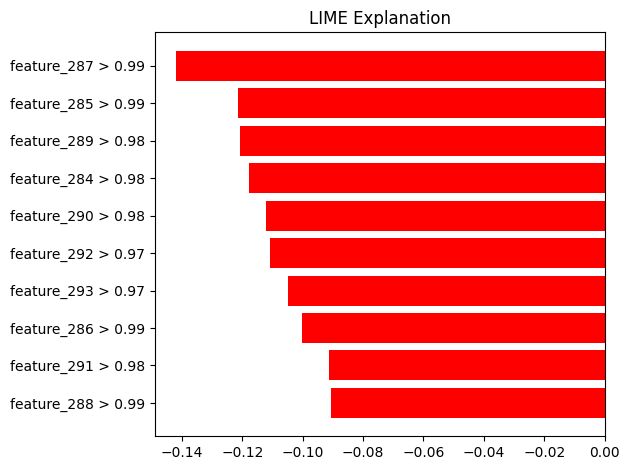


SHAP Explanation:


ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 671!

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
from lime import lime_tabular
import shap
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('best_tabular_model.h5')

# Load and preprocess your data
    # Implement your data  logic here
    # Should return X_train, X_test, y_train, y_test, feature_names,


# =====================
# 1. Fixed LIME Explanation
# =====================
def lime_explanation(model, sample, feature_names, class_names=['Fake', 'Real']):
    # Create wrapper function that outputs probabilities for both classes
    def predict_proba(x):
        preds = model.predict(x, verbose=0)
        # Convert single probability to two-class probabilities
        return np.hstack([1-preds, preds])

    explainer = lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )

    exp = explainer.explain_instance(
        sample,
        predict_proba,  # Use our wrapper function
        num_features=10
    )

    # Visualization
    fig = plt.figure(figsize=(10, 5))
    exp.as_pyplot_figure()
    plt.title("LIME Explanation")
    plt.tight_layout()
    plt.show()

    return exp

# =====================
# 2. SHAP Explanation
# =====================
def shap_explanation(model, sample, background_samples=100):
    # Create SHAP explainer
    explainer = shap.Explainer(
        model,
        X_train[:background_samples]  # Use subset for background
    )

    # Calculate SHAP values
    shap_values = explainer(sample.reshape(1, -1))

    # Visualization
    plt.figure(figsize=(12, 6))
    shap.plots.bar(shap_values[0], max_display=10)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()

    return shap_values

# =====================
# 3. Grad-CAM Style Explanation
# =====================
def grad_cam_explanation(model, sample, feature_names):
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        pred = model(sample_tensor)

    # Get gradients of output w.r.t input
    grads = tape.gradient(pred, sample_tensor).numpy()[0]

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.barh(feature_names, grads)
    plt.xlabel("Gradient Magnitude")
    plt.title("Grad-CAM Style Input Gradient Importance")
    plt.tight_layout()
    plt.show()

    return grads

# =====================
# Main Execution
# =====================
if __name__ == "__main__":
    # Select random samples to explain
    sample_indices = np.random.choice(len(X_test), 3, replace=False)

    for idx in sample_indices:
        sample = X_test[idx]
        true_label = y_test[idx]
        pred = model.predict(sample.reshape(1, -1))[0][0]
        pred_class = 'Real' if pred > 0.5 else 'Fake'

        print(f"\nSample {idx}:")
        print(f"True: {'Real' if true_label == 1 else 'Fake'}")
        print(f"Predicted: {pred_class} ({pred:.4f})")

        # Generate explanations
        print("\nLIME Explanation:")
        lime_exp = lime_explanation(model, sample, feature_names)

        print("\nSHAP Explanation:")
        shap_vals = shap_explanation(model, sample)

        print("\nGrad-CAM Style Explanation:")
        gradients = grad_cam_explanation(model, sample, feature_names)

        # Print top features from each method
        print("\nTop Contributing Features:")
        lime_features = sorted(lime_exp.as_list(), key=lambda x: abs(x[1]), reverse=True)[:5]

        # Handle SHAP values differently since we're using the new API
        print("\nLIME Top Features:")
        for feat, weight in lime_features:
            print(f"{feat}: {weight:.4f}")

        print("\nSHAP Top Features:")
        for feat, val in zip(feature_names, shap_vals.values[0,:,1]):
            print(f"{feat}: {val:.4f}")

        print("\nGradient Top Features:")
        for feat, grad in zip(feature_names, gradients):
            print(f"{feat}: {grad:.4f}")

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
from lime import lime_tabular
import shap
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('best_tabular_model.h5')

# Load and preprocess your data
def load_and_preprocess(data_path):
    # Implement your data loading logic here
    # Should return X_train, X_test, y_train, y_test, feature_names, scaler
    pass

data_path = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
X_train, X_test, y_train, y_test, feature_names, scaler = load_and_preprocess(data_path)

# =====================
# 1. Fixed LIME Explanation
# =====================
def lime_explanation(model, sample, feature_names, class_names=['Fake', 'Real']):
    # Create wrapper function that outputs probabilities for both classes
    def predict_proba(x):
        preds = model.predict(x, verbose=0)
        # Convert single probability to two-class probabilities
        return np.hstack([1-preds, preds])

    explainer = lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )

    exp = explainer.explain_instance(
        sample,
        predict_proba,  # Use our wrapper function
        num_features=10
    )

    # Visualization
    fig = plt.figure(figsize=(10, 5))
    exp.as_pyplot_figure()
    plt.title("LIME Explanation")
    plt.tight_layout()
    plt.show()

    return exp

# =====================
# 2. SHAP Explanation
# =====================
def shap_explanation(model, sample, background_samples=100):
    # Create SHAP explainer
    explainer = shap.Explainer(
        model,
        X_train[:background_samples]  # Use subset for background
    )

    # Calculate SHAP values
    shap_values = explainer(sample.reshape(1, -1))

    # Visualization
    plt.figure(figsize=(12, 6))
    shap.plots.bar(shap_values[0], max_display=10)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()

    return shap_values

# =====================
# 3. Grad-CAM Style Explanation
# =====================
def grad_cam_explanation(model, sample, feature_names):
    sample_tensor = tf.convert_to_tensor(sample.reshape(1, -1), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(sample_tensor)
        pred = model(sample_tensor)

    # Get gradients of output w.r.t input
    grads = tape.gradient(pred, sample_tensor).numpy()[0]

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.barh(feature_names, grads)
    plt.xlabel("Gradient Magnitude")
    plt.title("Grad-CAM Style Input Gradient Importance")
    plt.tight_layout()
    plt.show()

    return grads

# =====================
# Main Execution
# =====================
if __name__ == "__main__":
    # Select random samples to explain
    sample_indices = np.random.choice(len(X_test), 3, replace=False)

    for idx in sample_indices:
        sample = X_test[idx]
        true_label = y_test[idx]
        pred = model.predict(sample.reshape(1, -1))[0][0]
        pred_class = 'Real' if pred > 0.5 else 'Fake'

        print(f"\nSample {idx}:")
        print(f"True: {'Real' if true_label == 1 else 'Fake'}")
        print(f"Predicted: {pred_class} ({pred:.4f})")

        # Generate explanations
        print("\nLIME Explanation:")
        lime_exp = lime_explanation(model, sample, feature_names)

        print("\nSHAP Explanation:")
        shap_vals = shap_explanation(model, sample)

        print("\nGrad-CAM Style Explanation:")
        gradients = grad_cam_explanation(model, sample, feature_names)

        # Print top features from each method
        print("\nTop Contributing Features:")
        lime_features = sorted(lime_exp.as_list(), key=lambda x: abs(x[1]), reverse=True)[:5]

        # Handle SHAP values differently since we're using the new API
        print("\nLIME Top Features:")
        for feat, weight in lime_features:
            print(f"{feat}: {weight:.4f}")

        print("\nSHAP Top Features:")
        for feat, val in zip(feature_names, shap_vals.values[0,:,1]):
            print(f"{feat}: {val:.4f}")

        print("\nGradient Top Features:")
        for feat, grad in zip(feature_names, gradients):
            print(f"{feat}: {grad:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step

Sample 302:
True: Real
Predicted: Real (1.0000)

LIME Explanation:
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


IndexError: index 1 is out of bounds for axis 1 with size 1

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (15,) + inhomogeneous part.

In [4]:
!pip install shap

  Using cached shap-0.47.2-cp311-cp311-win_amd64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
Using cached shap-0.47.2-cp311-cp311-win_amd64.whl (544 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)


C:\Users\adity\AppData\Local\Temp\ipykernel_25496\488601609.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050)
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/Real/example.wav'

In [11]:
!pip install keras==2.11.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires keras>=3.5.0, but you have keras 2.11.0 which is incompatible.


   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 4.2 MB/s eta 0:00:01
   ------------------------------- -------- 1.3/1.7 MB 4.5 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 4.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1


In [13]:
!pip install tensorflow==2.11.0


ERROR: Could not find a version that satisfies the requirement tensorflow==2.11.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.11.0


In [ ]:
!pip uninstall keras tensorflow
!pip install tensorflow==2.13.0 keras==2.13.1


^C


ERROR: Could not find a version that satisfies the requirement tensorflow==2.13.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.13.0
